# Figure 4

# Loading the data

Here we load all the packages that we need, and import the data (pickled by a preprocessing notebook).

## Loading packages

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
from IPython.display import display # Pretty display of data frames.

# Plotting
import matplotlib.pyplot as plt  # For basic plotting.
import matplotlib.transforms as transforms
import matplotlib.colors as pcolors
from matplotlib.patches import Rectangle
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

# Stats and scipy
import statsmodels.api as sm
import scipy.stats as ss
import scipy.cluster.hierarchy as sch # For hierarchical clustering.


from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# UMAPs are all the rage... no more tSNE. Sad :(
import umap

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

In [3]:
def setfontsize():
    SMALL_SIZE = 5
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 7

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
def desetfontsize():
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
plt.rcParams['font.sans-serif'] = 'Helvetica'
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))
font

'/System/Library/Fonts/Helvetica.ttc'

Check figure below to see that Helvetica is being used.

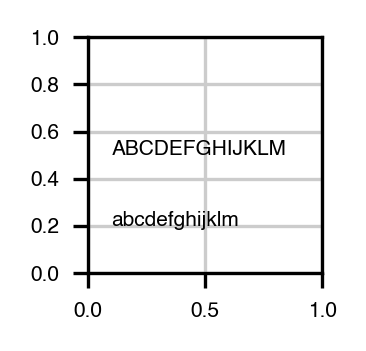

In [6]:
setfontsize()
fig,ax = plt.subplots(1,1,figsize=(1,1), dpi=300)
ax.text(0.1,0.5,'ABCDEFGHIJKLM')
ax.text(0.1,0.2, 'abcdefghijklm')
plt.show()

In [7]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

## Loading the data

Here we load the expression matrices and metadata, in anndata files.

In [6]:
import anndata

ad_mib = anndata.read_loom('merged_integrated_batchcorr_270721.loom')
ad_mib.var_names = ad_mib.var['gene_name']
ad_mib.obs_names = ad_mib.obs['obs_names']

/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
donordays = ad_mib.obs.DonorDay.unique()
donordays

array(['A1_06_D14', 'A1_06_D180', 'A1_30_D14', 'A1_30_D180', 'JH_D2000',
       'JH_D14', 'YFV2003_D1401', 'YFV2003_D15'], dtype=object)

In [8]:
adata = {}
for dd in donordays:
    adata[dd] = ad_mib[ad_mib.obs.DonorDay == dd]

This is the loading the old data files that I preprocessed.

In [9]:
#experiment = 'umi'
#file_prefix = 'anndata'
#file_suffix = '.loom'  
#datasets = ['A1_06_D14', 'A1_06_D180', 'A1_30_D14', 'A1_30_D180', 'JH_D14', 'JH_D2000', 'YFV2003_D15']

# Sample filename:  anndata_biginvivo_A1_06_D14.loom
#adata = {}
#for ds in datasets:
#    fn = file_prefix+'_'+experiment+'_'+ds+file_suffix
#    print('Reading from {}'.format(fn))
#    adata[ds] = anndata.read_loom(fn)
#    adata[ds].var_names = adata[ds].var['gene_name']
#    adata[ds].obs_names = adata[ds].obs['obs_names']

In [10]:
data_late = ['A1_06_D180', 'A1_30_D180', 'JH_D2000']
data_late

['A1_06_D180', 'A1_30_D180', 'JH_D2000']

## Celltype distribution, late timepoints

(Skip this until we have celltype (MEM/EFF) scores.

In [11]:
# Abbreviations for exploration

a6 = 'A1_06_D180'
a30 = 'A1_30_D180'
jh = 'JH_D2000'

AttributeError: 'DataFrameView' object has no attribute 'Celltype'

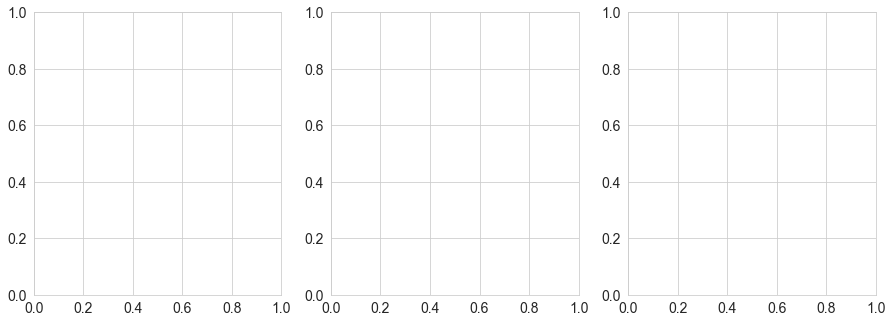

In [12]:
sns.set_style('whitegrid')
fig,ax = plt.subplots(1,3,figsize=(15,5))
for j,ds in enumerate(data_late):
    sns.histplot(adata[ds].obs.Celltype, ax=ax[j], kde=True)
    ax[j].set_title(ds)
plt.show()

## Celltype distribution at day 14.

In [11]:
data_early = ['A1_06_D14','A1_30_D14', 'JH_D14']
data_early

['A1_06_D14', 'A1_30_D14', 'JH_D14']

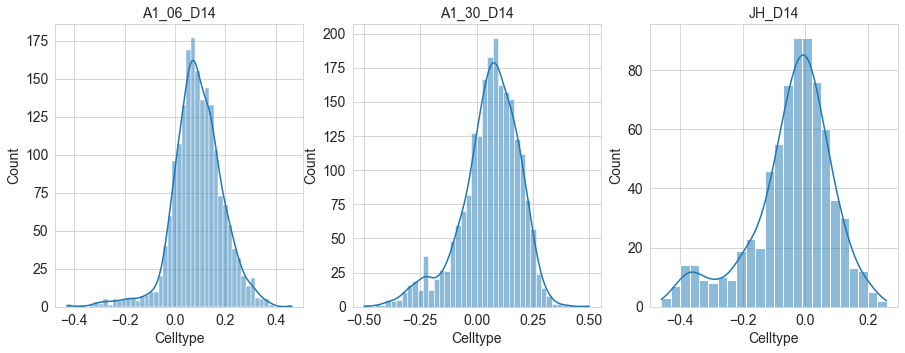

In [12]:
sns.set_style('whitegrid')
fig,ax = plt.subplots(1,3,figsize=(15,5))
for j,ds in enumerate(data_early):
    sns.histplot(adata[ds].obs.Celltype, ax=ax[j], kde=True)
    ax[j].set_title(ds)
plt.show()

## Examination of clone populations

In [12]:
clonepops = {}

for ds in donordays:
    clonepops[ds] = adata[ds].obs.clone_id.value_counts()

for ds in donordays:
    print('Largest 21 clones in {} (including bad clone 0):'.format(ds))
    cp_table = pd.DataFrame(clonepops[ds][:21])
    cp_table.columns = ['Clone population']
    display(cp_table.T)
    hrule()

Largest 21 clones in A1_06_D14 (including bad clone 0):


A61  A0  A154  A28  A36  A3  A47  A39  A9  A48  ...  A177  \
Clone population   73  65    52   38   34  33   31   30  29   28  ...    25   

                  A1  A137  A142  A94  A330  A70  A584  A55  A22  
Clone population  21    20    19   16    14   14    12   12   11  

[1 rows x 21 columns]

Largest 21 clones in A1_06_D180 (including bad clone 0):


A0  A47  A48  A61  A39  A154  A159  A177  A3  A9  ...  A31  \
Clone population  122   43   29   25   24    23    20    20  19  18  ...   14   

                  A57  A171  A5  A19  A74  A113  A360  A65  A192  
Clone population   14    13  13   12   12    12    11   11    11  

[1 rows x 21 columns]

Largest 21 clones in A1_30_D14 (including bad clone 0):


B0  B205  B63  B165  B85  B71  B81  B101  B57  B102  ...  \
Clone population  48    31   26    21   15   15   14    14   13    13  ...   

                  B83  B69  B212  B243  B176  B858  B744  B96  B664  B396  
Clone population   12   10    10     9     9     9     9    8     8     8  

[1 rows x 21 columns]

Largest 21 clones in A1_30_D180 (including bad clone 0):


B0  B39  B66  B12  B8  B71  B102  B24  B7  B44  ...  B211  \
Clone population  83   59   44   35  34   30    29   24  24   23  ...    19   

                  B100  B212  B488  B72  B122  B60  B185  B33  B225  
Clone population    19    17    16   14    14   13    12   12    12  

[1 rows x 21 columns]

Largest 21 clones in JH_D2000 (including bad clone 0):


C0  C35  C27  C154  C107  C87  C29  C75  C38  C67  ...  \
Clone population  116   32   27    27    26   23   18   18   18   17  ...   

                  C112  C16  C17  C26  C318  C126  C81  C50  C151  C11  
Clone population    14   14   13   13    13    12   12   11    11   11  

[1 rows x 21 columns]

Largest 21 clones in JH_D14 (including bad clone 0):


C0  C26  C42  C22  C77  C64  C12  C18  C135  C107  ...  C35  \
Clone population  50   42   30   29   14   13   12   12    11    11  ...   10   

                  C99  C7  C75  C101  C46  C240  C199  C203  C60  
Clone population    9   9    8     8    8     8     8     7    6  

[1 rows x 21 columns]

Largest 21 clones in YFV2003_D1401 (including bad clone 0):


D212  D0  D209  D19  D122  D539  D396  D364  D525  D118  \
Clone population    23  15    14   13    11     7     7     6     6     6   

                  ...  D146  D865  D120  D268  D4  D74  D1014  D450  D258  \
Clone population  ...     5     5     5     5   4    4      4     4     4   

                  D418  
Clone population     4  

[1 rows x 21 columns]

Largest 21 clones in YFV2003_D15 (including bad clone 0):


D0  D106  D19  D49  D74  D10  D124  D268  D122  D78  ...  \
Clone population  124    40   39   36   31   26    20    20    19   18  ...   

                  D57  D245  D81  D34  D378  D15  D255  D235  D266  D80  
Clone population   17    17   16   14    14   14    14    14    14   13  

[1 rows x 21 columns]

In [13]:
bigclones = {}
for ds in donordays:
    bigclones[ds] = list(clonepops[ds][1:21].index)
    print('Big (nonzero) clones for {} are {}.'.format(ds, ', '.join(bigclones[ds])))
    hrule()

Big (nonzero) clones for A1_06_D14 are A0, A154, A28, A36, A3, A47, A39, A9, A48, A155, A177, A1, A137, A142, A94, A330, A70, A584, A55, A22.
Big (nonzero) clones for A1_06_D180 are A47, A48, A61, A39, A154, A159, A177, A3, A9, A60, A31, A57, A171, A5, A19, A74, A113, A360, A65, A192.
Big (nonzero) clones for A1_30_D14 are B205, B63, B165, B85, B71, B81, B101, B57, B102, B293, B83, B69, B212, B243, B176, B858, B744, B96, B664, B396.
Big (nonzero) clones for A1_30_D180 are B39, B66, B12, B8, B71, B102, B24, B7, B44, B304, B211, B100, B212, B488, B72, B122, B60, B185, B33, B225.
Big (nonzero) clones for JH_D2000 are C35, C27, C154, C107, C87, C29, C75, C38, C67, C25, C112, C16, C17, C26, C318, C126, C81, C50, C151, C11.
Big (nonzero) clones for JH_D14 are C26, C42, C22, C77, C64, C12, C18, C135, C107, C123, C35, C99, C7, C75, C101, C46, C240, C199, C203, C60.
Big (nonzero) clones for YFV2003_D1401 are D0, D209, D19, D122, D539, D396, D364, D525, D118, D503, D146, D865, D120, D268, D4, D7

In [14]:
donors = ['A1_06','A1_30', 'JH']

In [15]:
timeclones = {}
for donor in donors:
    timepoints = [dd for dd in donordays if donor in dd]
    print('Looking at {}'.format(timepoints))
    timeclones[donor] = [clone for clone in bigclones[timepoints[0]] if clone in bigclones[timepoints[1]]]
    print('The following clones are big at both timepoints in {}:  {}'.format(donor, ', '.join(timeclones[donor])))

Looking at ['A1_06_D14', 'A1_06_D180']
The following clones are big at both timepoints in A1_06:  A154, A3, A47, A39, A9, A48, A177
Looking at ['A1_30_D14', 'A1_30_D180']
The following clones are big at both timepoints in A1_30:  B71, B102, B212
Looking at ['JH_D2000', 'JH_D14']
The following clones are big at both timepoints in JH:  C35, C107, C75, C26


# Plate examination

In [16]:
for ds in donordays:
    print(ds, adata[ds].obs.batch.unique())

A1_06_D14 ['0' '1' '2' '3' '4' '5']
A1_06_D180 ['6' '7' '8' '9' '10']
A1_30_D14 ['11' '12' '13' '14' '15' '16']
A1_30_D180 ['17' '18' '19' '20' '21']
JH_D2000 ['22' '23' '24' '25']
JH_D14 ['26' '27' '28']
YFV2003_D1401 ['29' '30']
YFV2003_D15 ['31' '32' '33' '34' '35' '36' '37' '38']


In [17]:
for ds in donordays:
    for clone in adata[ds].obs.clone_id.unique():
        adc = adata[ds][adata[ds].obs.clone_id == clone]
        clonepop = len(adc.obs_names)
        if clonepop > 30:
            print('In {}, clone {} has {} cells in batches: {}'.format(ds, clone, clonepop, 
                                                                       ', '.join(adc.obs.batch.unique())))

In A1_06_D14, clone A36 has 34 cells in batches: 0, 1, 2, 3, 4, 5
In A1_06_D14, clone A28 has 38 cells in batches: 0, 1, 2, 3, 4, 5
In A1_06_D14, clone A3 has 33 cells in batches: 0, 1, 2, 3, 4, 5
In A1_06_D14, clone A47 has 31 cells in batches: 0, 1, 2, 3, 4, 5
In A1_06_D14, clone A154 has 52 cells in batches: 0, 1, 2, 3, 4, 5
In A1_06_D14, clone A0 has 65 cells in batches: 0, 1, 2, 3, 4, 5
In A1_06_D14, clone A61 has 73 cells in batches: 0, 1, 2, 3, 4, 5
In A1_06_D180, clone A0 has 122 cells in batches: 6, 7, 8, 9, 10
In A1_06_D180, clone A47 has 43 cells in batches: 6, 7, 8, 9, 10
In A1_30_D14, clone B0 has 48 cells in batches: 11, 12, 13, 14, 15, 16
In A1_30_D14, clone B205 has 31 cells in batches: 11, 12, 13, 14, 15, 16
In A1_30_D180, clone B39 has 59 cells in batches: 17, 18, 19, 20, 21
In A1_30_D180, clone B66 has 44 cells in batches: 17, 18, 19, 20, 21
In A1_30_D180, clone B12 has 35 cells in batches: 17, 18, 19, 20, 21
In A1_30_D180, clone B0 has 83 cells in batches: 17, 18, 1

In [49]:
batch_clones = ['B39', 'B66', 'B12', 'B8']
ad_batch = ads['A1_30_D180']
ad_batch = ad_batch[ad_batch.obs.clone_id.isin(batch_clones)]
ad_batch

View of AnnData object with n_obs × n_vars = 172 × 10963
    obs: 'Donor', 'DonorDay', 'G2M_score', 'S_score', 'Timepoint', 'XIST-counts', 'batch', 'cellcycle', 'clone_id', 'doublet_info', 'doublet_scores', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'pct_counts_rb', 'percent_chrY', 'phase', 'predicted_doublets', 'total_counts', 'total_counts_mt', 'total_counts_rb', 'Shuffle_0', 'Shuffle_1', 'Shuffle_2', 'Shuffle_3', 'Shuffle_4', 'Shuffle_5', 'Shuffle_6', 'Shuffle_7', 'Shuffle_8', 'Shuffle_9', 'Shuffle_10', 'Shuffle_11', 'Shuffle_12', 'Shuffle_13', 'Shuffle_14', 'Shuffle_15', 'Shuffle_16', 'Shuffle_17', 'Shuffle_18', 'Shuffle_19', 'Shuffle_20', 'Shuffle_21', 'Shuffle_22', 'Shuffle_23', 'Shuffle_24', 'Shuffle_25', 'Shuffle_26', 'Shuffle_27', 'Shuffle_28', 'Shuffle_29', 'Shuffle_30', 'Shuffle_31', 'Shuffle_32', 'Shuffle_33', 'Shuffle_34', 'Shuffle_35', 'Shuffle_36', 'Shuffle_37', 'Shuffle_38', 'Shuffle_39', 'Shuffle_40', 'Shuffle_41', 'Shuffle_42', 'Shuffle_

Trying to set attribute `.uns` of view, copying.


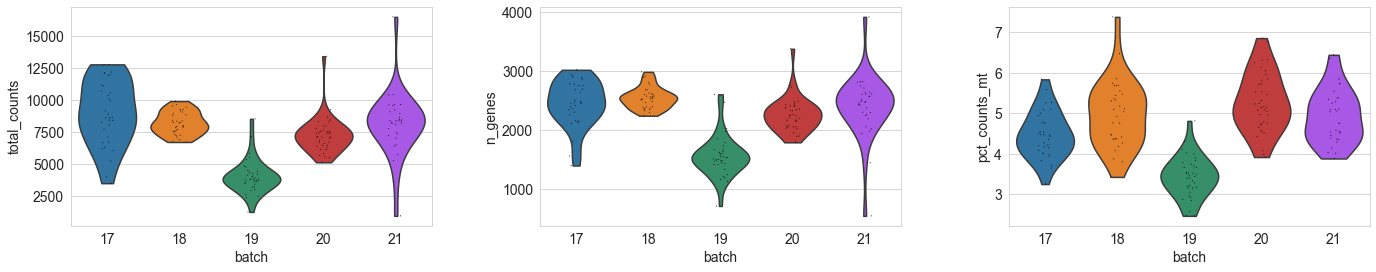

In [50]:
sc.pl.violin(ad_batch, ['total_counts', 'n_genes', 'pct_counts_mt'], groupby='batch')

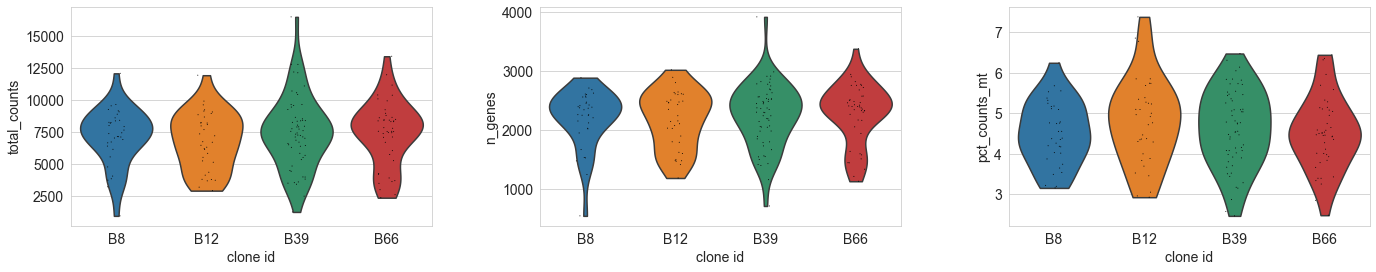

In [51]:
sc.pl.violin(ad_batch, ['total_counts', 'n_genes', 'pct_counts_mt'], groupby='clone_id')

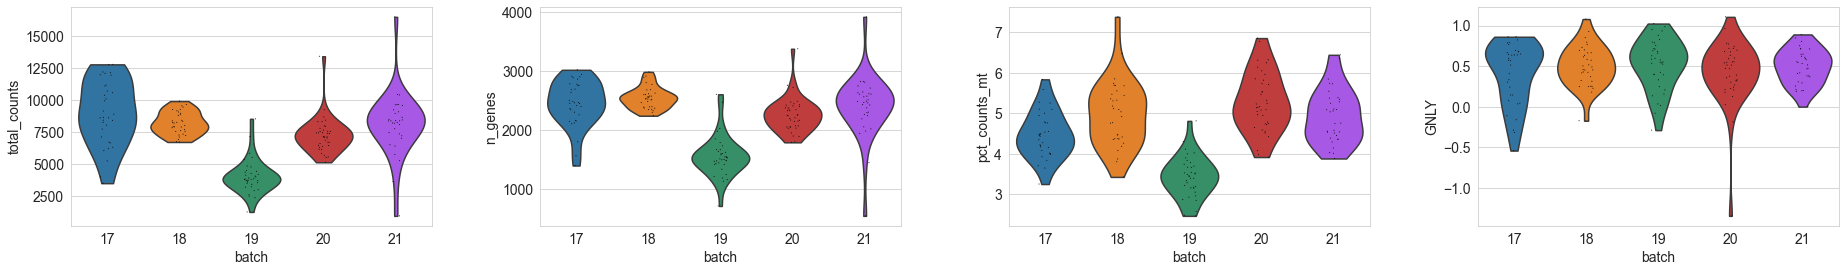

In [52]:
sc.pl.violin(ad_batch, ['total_counts', 'n_genes', 'pct_counts_mt', 'GNLY'], groupby='batch')

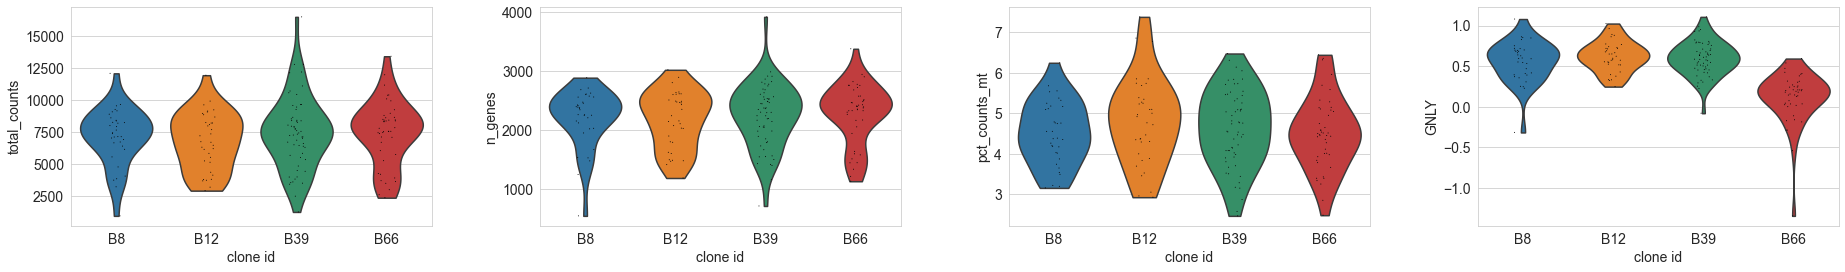

In [53]:
sc.pl.violin(ad_batch, ['total_counts', 'n_genes', 'pct_counts_mt', 'GNLY'], groupby='clone_id')

In [54]:
ad_batch.obs['cb'] = (ad_batch.obs.clone_id.astype(str) + '_batch' + ad_batch.obs.batch.astype(str))

... storing 'cb' as categorical


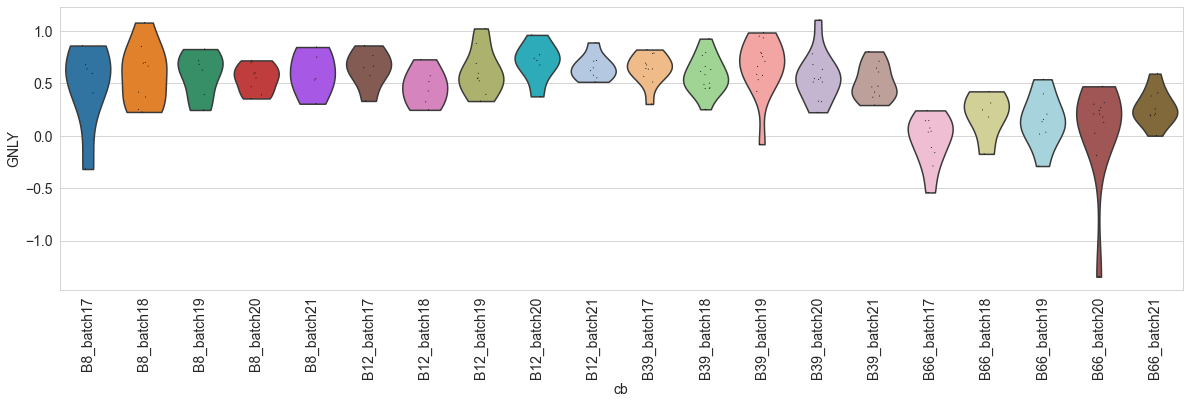

In [55]:
sns.set_style('whitegrid')
fig,ax = plt.subplots(1,1,figsize=(20,5))
sc.pl.violin(ad_batch, ['GNLY'], groupby='cb', ax=ax, show=False)
plt.xticks(rotation = 90)
plt.show()

In [318]:
ad_batch = ad_batch.copy()

In [319]:
sc.pp.combat(ad_batch)

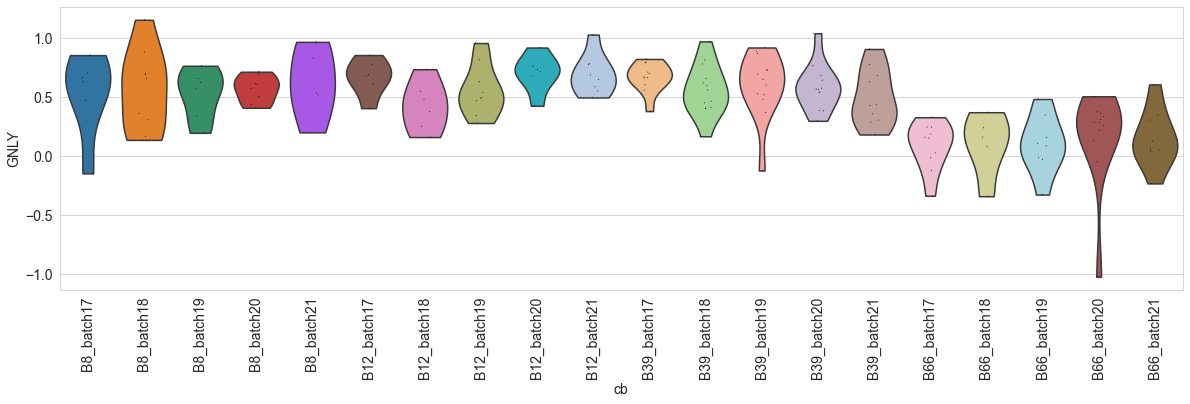

In [320]:
sns.set_style('whitegrid')
fig,ax = plt.subplots(1,1,figsize=(20,5))
sc.pl.violin(ad_batch, ['GNLY'], groupby='cb', ax=ax, show=False)
plt.xticks(rotation = 90)
plt.show()

# Early timepoints -- cell cycle and cell type

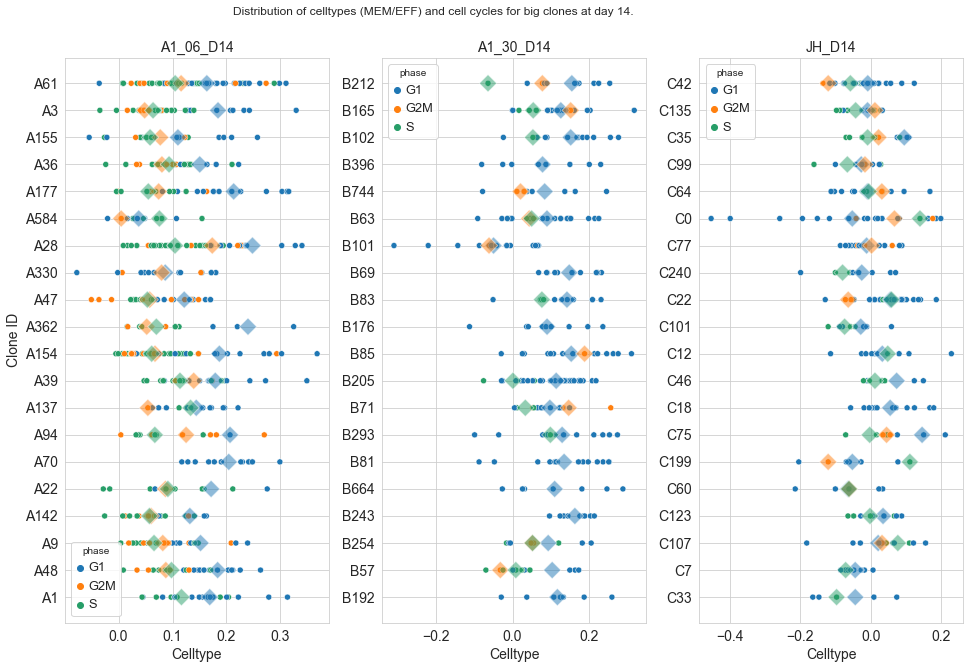

In [21]:
fig,ax = plt.subplots(1,3,figsize=(16,10))

for j,ds in enumerate(data_early):
    plot_df = adata[ds][adata[ds].obs.clone_id.isin(bigclones[ds])].obs
    #display(plot_df)
    ct_means = pd.DataFrame(plot_df.groupby(['clone_id','phase']).mean()['Celltype'], columns=['Celltype'])
    #display(ct_means)
    sns.scatterplot(x='Celltype', y = 'clone_id', hue='phase', 
                    hue_order = ['G1','G2M','S'],
                    data=plot_df, ax=ax[j])
    sns.scatterplot(x='Celltype', y='clone_id', hue='phase', 
                    hue_order = ['G1','G2M','S'],
                    data=ct_means, ax=ax[j], marker='D', s=150, alpha=0.5, legend=False)
    if j == 0:
        ax[j].set_ylabel('Clone ID')
    else:
        ax[j].set_ylabel('')
    ax[j].set_title(ds)
plt.suptitle('Distribution of celltypes (MEM/EFF) and cell cycles for big clones at day 14.')
plt.show()

## Clonality of cell type scores

In [18]:
def clonal_ct_fig(ad, clonelist, verbose=False):
    ad_clones = ad.obs.clone_id.copy()
    ad_clones = ad_clones[ad_clones.isin(clonelist)]
    plot_df = pd.DataFrame(columns = ['Celltype score','Clone ID'])
    plot_df['Clone ID'] = ad_clones
    plot_df['Celltype score'] = ad.obs.Celltype.loc[ad_clones.index]
    plot_df['SELL'] = ad.to_df()['SELL'].loc[ad_clones.index]
    
    clonesort = list(plot_df.groupby('Clone ID')['Celltype score'].mean().sort_values().index)
    plot_df['Clone ID'] = pd.Categorical(plot_df['Clone ID'], clonesort)
    plot_df = plot_df.sort_values('Clone ID')
    
    if verbose:
        display(plot_df)
    fig,ax = plt.subplots(1,1,figsize=(6,len(clonelist)*0.5))
    sns.scatterplot(x='Celltype score', y='Clone ID', hue='Celltype score', data=plot_df, legend=False)
    ax.axvline(0, color='gray')
    plt.show()

In [19]:
def clonal_ct_ridges(ad, clonelist, verbose=False):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Create the data
    ad_clones = ad.obs.clone_id.copy()
    ad_clones = ad_clones[ad_clones.isin(clonelist)]
    plot_df = pd.DataFrame(columns = ['Celltype score','Clone ID'])
    plot_df['Clone ID'] = ad_clones
    plot_df['Celltype score'] = ad.obs.Celltype.loc[ad_clones.index]
    
    clonesort = list(plot_df.groupby('Clone ID')['Celltype score'].mean().sort_values().index)
    plot_df['Clone ID'] = pd.Categorical(plot_df['Clone ID'], clonesort)
    plot_df = plot_df.sort_values('Clone ID')
    
    if verbose:
        display(plot_df)

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(len(clonelist), rot=-.25, light=.7)
    g = sns.FacetGrid(plot_df, row="Clone ID", hue="Clone ID", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Celltype score",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
                                
    
    g.map(sns.kdeplot, "Celltype score", clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    
    g.map(label, "Celltype score")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.suptitle('Clonality of MEM/EFF celltype scores in {}'.format(ad.obs.DonorDay[0]))
    plt.show()
                                

In [20]:
data_late

['A1_06_D180', 'A1_30_D180', 'JH_D2000']

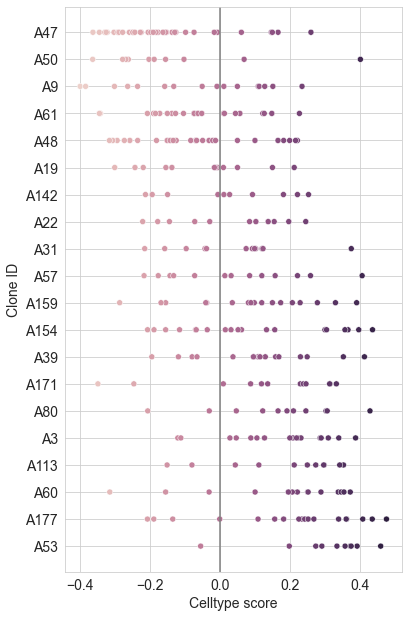

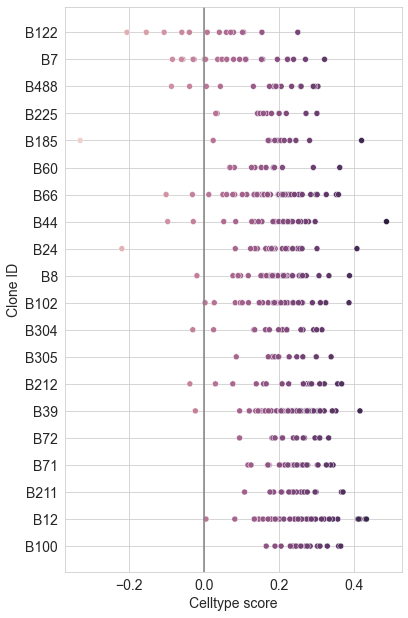

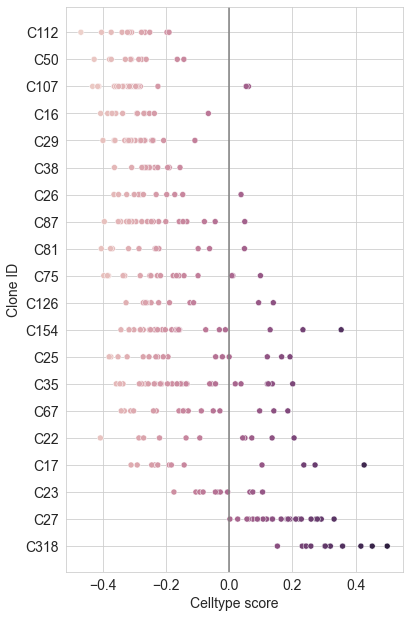

In [26]:
for ds in data_late:
    clonal_ct_fig(adata[ds], bigclones[ds])

## Timepoint celltype correlation

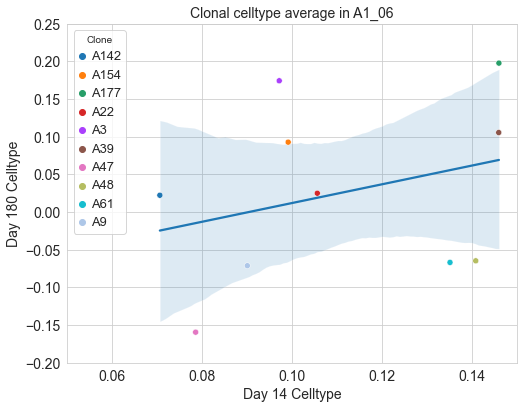

In [27]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for j,donor in enumerate(donors[:1]):
    ad_early = adata[donor+'_D14'][adata[donor+'_D14'].obs.clone_id.isin(timeclones[donor])]
    ad_late = adata[donor+'_D180'][adata[donor+'_D180'].obs.clone_id.isin(timeclones[donor])]
    ct_early = ad_early.obs.groupby('clone_id').Celltype.mean()
    ct_late = ad_late.obs.groupby('clone_id').Celltype.mean()
    plot_df = pd.DataFrame(index = ct_early.index)
    plot_df['Day 14 Celltype'] = ct_early
    plot_df['Day 180 Celltype'] = ct_late
    plot_df['Clone'] = ct_early.index
    sns.regplot(x='Day 14 Celltype', y='Day 180 Celltype', 
                data = plot_df, ax=ax, scatter=False)
    sns.scatterplot(x='Day 14 Celltype', y='Day 180 Celltype', hue='Clone',
                    data = plot_df, ax=ax)
    ax.set_title('Clonal celltype average in {}'.format(donor))
    ax.set_xlim(0.05,0.15)
    ax.set_ylim(-0.2,0.25)
    #display(ct_early)
    #display(ct_late)
    #print(timeclones[donor])
plt.show()

## Clonal gene signatures

In [21]:
def get_cells(ad, ct_min = 0.1, ct_max = 0.4, minclonepop = 20, exclude_zero = True):
    print('{} cells in this data set.'.format(len(ad.to_df())))
    # ad_ct = ad[ad.obs.Celltype >= ct_min]
    # ad_ct = ad_ct[ad_ct.obs.Celltype <= ct_max]
    # print('{} cells with celltype score between {} and {}'.format(len(ad_ct.to_df()), ct_min, ct_max))
    
    ad_ct = ad
    
    cpops = ad_ct.obs.clone_id.value_counts()
    if exclude_zero:
        badclone = cpops.index[0][0] + '0'
        cpops = cpops.drop(badclone)
    cpops = cpops[cpops >= minclonepop]
    ad_ct = ad_ct[ad_ct.obs.clone_id.isin(cpops.index)]
    print('{} cells found in {} clones with at least {} cells each'.format(len(ad_ct.to_df()), 
                                                                           len(cpops),
                                                                          minclonepop))
    return ad_ct

In [22]:
data_late

['A1_06_D180', 'A1_30_D180', 'JH_D2000']

In [23]:
ads = {}
for ds in data_late:
    print('Processing {}'.format(ds))
    ads[ds] = get_cells(adata[ds], ct_min = -0.5, ct_max = 0.5, minclonepop=20)
    # Batch correction!
    sc.pp.combat(ads[ds])
    hrule()

/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'Donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'DonorDay' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'clone_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'doublet_info' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'phase' as categorical


Processing A1_06_D180
1634 cells in this data set.
184 cells found in 7 clones with at least 20 cells each


/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'Donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'DonorDay' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'clone_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'doublet_info' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'phase' as categorical


Processing A1_30_D180
1719 cells in this data set.
322 cells found in 10 clones with at least 20 cells each


/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'Donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'DonorDay' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'clone_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'doublet_info' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'phase' as categorical


Processing JH_D2000
1279 cells in this data set.
135 cells found in 5 clones with at least 20 cells each


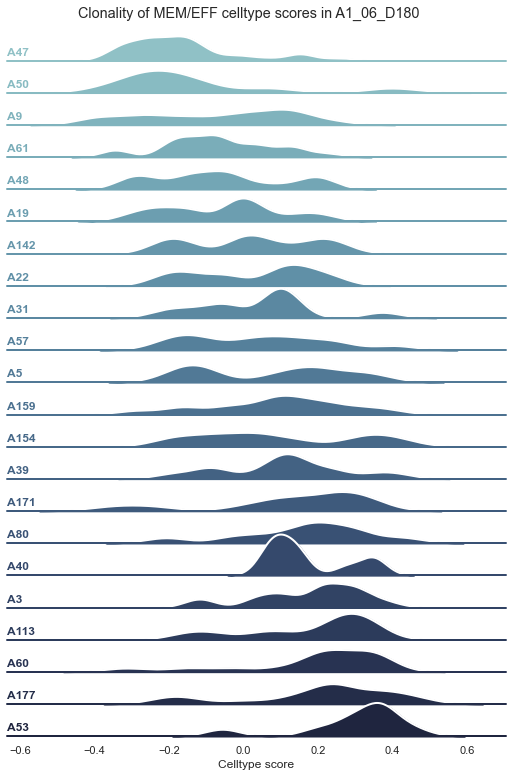

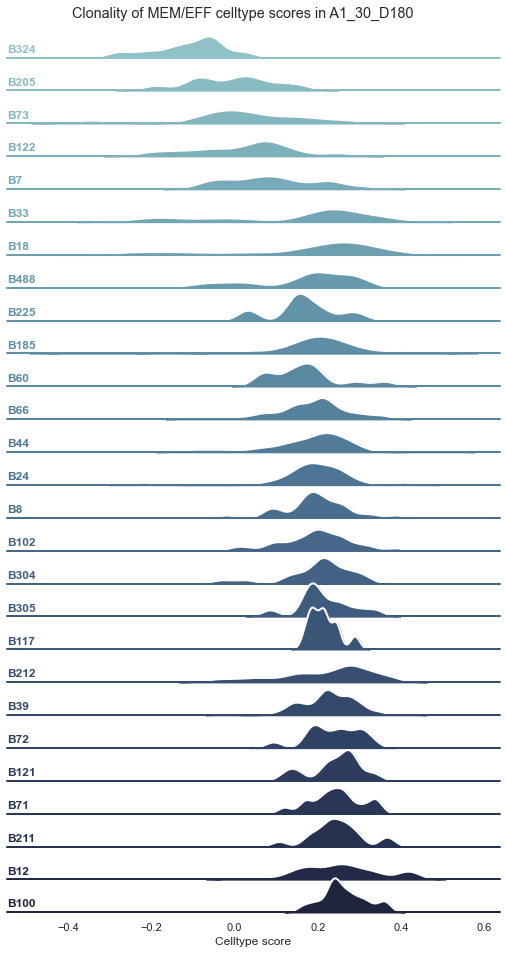

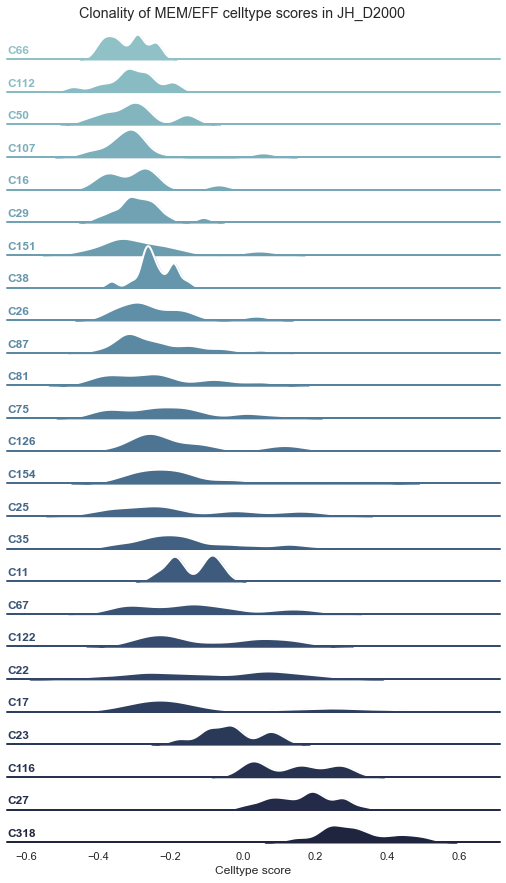

In [322]:
for ds in data_late:
    clonal_ct_ridges(ads[ds], ads[ds].obs.clone_id.unique())

# Adding permuted labels to AnnData objects

We will be running permutation tests to find clonal signals in our data.  For this purpose, we will permute the clone-labels on many of our cells (within each celltype and brain).  

The following is a specialized tool for permutation tests.  It produes permutations which disrupt existing group structures.  For example, if we want 10 permutations of clone labels, we produce 100 permutations instead.  We "score" these by looking at how many distinct labels each old clone receives.  I.e., if an old clone A has three cells 1,2,3, and these are assigned labels B,C,D instead of A,A,A, then we give it a score of 3 (three distinct labels).  We then take the top 10 permutations, by this score.  

This mitigates some issues with clonal structure being preserved by some permutations and not by others... a significant issue when there are pretty small samples.

In [24]:
def make_shuff(meta, no_shuffs=10, topratio = 10):
    tot_shuffs = no_shuffs * topratio
    ms_df = pd.DataFrame(index=meta.index, columns=range(tot_shuffs))
    ms_df = pd.concat([meta.astype(str) for j in range(tot_shuffs)], axis=1)
    
    ms_vals = ms_df.values
    [np.random.shuffle(x) for x in ms_vals.T]
    
    ms_df.columns = ['Shuffle_{}'.format(j) for j in range(tot_shuffs)]
    scores = ms_df.groupby(meta).nunique().sum()
    good_shuffs = scores.sort_values()[-no_shuffs:].index
    ms_df = ms_df[good_shuffs].astype('category')
    ms_df.columns = ['Shuffle_{}'.format(j) for j in range(no_shuffs)]
    return ms_df

In [25]:
no_shuffs = 1100

for ds in data_late:
    ads[ds].obs.clone_id = ads[ds].obs.clone_id.astype(str)
    clone_shuffs = make_shuff(ads[ds].obs.clone_id, no_shuffs = no_shuffs)
    shuff_cols = clone_shuffs.columns
    ads[ds].obs[shuff_cols] = clone_shuffs
    print('Shuffled clone labels produced for dataset with {} cells'.format(ads[ds].shape[0]))

Shuffled clone labels produced for dataset with 184 cells
Shuffled clone labels produced for dataset with 322 cells
Shuffled clone labels produced for dataset with 135 cells


In [26]:
ads[ds].obs # Scroll right to see shuffled clone labels.

Donor  DonorDay  G2M_score   S_score  Timepoint  XIST-counts  \
obs_names                                                                    
JHDex_136-22     JH  JH_D2000  -0.188958 -0.179761     2000.0          1.0   
JHDex_280-22     JH  JH_D2000  -0.183432 -0.062068     2000.0         12.0   
JHDex_111-22     JH  JH_D2000  -0.194538 -0.025040     2000.0          2.0   
JHDex_183-22     JH  JH_D2000  -0.175420 -0.089036     2000.0          5.0   
JHDex_327-22     JH  JH_D2000  -0.103281  0.062274     2000.0          2.0   
...             ...       ...        ...       ...        ...          ...   
JHDex_1472-25    JH  JH_D2000  -0.153481  0.015894     2000.0         15.0   
JHDex_1506-25    JH  JH_D2000  -0.119410 -0.140986     2000.0          5.0   
JHDex_1330-25    JH  JH_D2000  -0.117243 -0.101291     2000.0         12.0   
JHDex_1402-25    JH  JH_D2000  -0.100483 -0.129344     2000.0          0.0   
JHDex_1516-25    JH  JH_D2000  -0.132503 -0.083163     2000.0          9.0   

              batch  cellcycle clone_id doublet_info  ...  Shuffle_1090  \
obs_names                                             ...                 
JHDex_136-22     22        1.0      C35        False  ...           C27   
JHDex_280-22     22        1.0      C87        False  ...          C154   
JHDex_111-22     22        0.0      C87        False  ...           C87   
JHDex_183-22     22        1.0      C35        False  ...           C35   
JHDex_327-22     22        0.0     C107        False  ...           C35   
...             ...        ...      ...          ...  ...           ...   
JHDex_1472-25    25        0.0     C154        False  ...           C35   
JHDex_1506-25    25        1.0      C35        False  ...          C107   
JHDex_1330-25    25        2.0      C87        False  ...           C27   
JHDex_1402-25    25        2.0      C87        False  ...           C87   
JHDex_1516-25    25        1.0      C35        False  ...          C107   

               Shuffle_1091  Shuffle_1092  Shuffle_1093 Shuffle_1094  \
obs_names                                                              
JHDex_136-22            C35          C154          C107         C154   
JHDex_280-22            C27           C87          C107         C107   
JHDex_111-22            C27          C154           C35         C107   
JHDex_183-22           C154           C35           C27         C154   
JHDex_327-22           C107           C27           C87         C154   
...                     ...           ...           ...          ...   
JHDex_1472-25           C35           C27           C27         C107   
JHDex_1506-25          C154           C35           C35          C27   
JHDex_1330-25           C27           C27          C107         C154   
JHDex_1402-25           C27           C27          C107          C35   
JHDex_1516-25           C35           C27           C27          C27   

               Shuffle_1095  Shuffle_1096  Shuffle_1097 Shuffle_1098  \
obs_names                                                              
JHDex_136-22            C27           C35          C154         C107   
JHDex_280-22           C154          C107           C87          C27   
JHDex_111-22            C35           C35          C154          C27   
JHDex_183-22            C87           C35           C27          C27   
JHDex_327-22           C107          C107           C35          C35   
...                     ...           ...           ...          ...   
JHDex_1472-25           C87           C35          C107          C27   
JHDex_1506-25           C35           C27           C87         C154   
JHDex_1330-25          C107           C35           C35          C35   
JHDex_1402-25           C87          C107          C154         C107   
JHDex_1516-25          C154          C154           C87         C154   

               Shuffle_1099  
obs_names                    
JHDex_136-22           C154  
JHDex_280-22           C154  
JHDex_111-22            C87  

In [27]:
from time import time
from scipy.stats import f_oneway

def make_pvals(ad, real_group, shuffle_label = 'Shuffle', no_shuffs=100):
    '''
    Expects an AnnData object ad.
    real_group is usually "cloneID", or the equivalent.
    Also expects a lot of shuffled real_group labels, called
    Shuffle_0, Shuffle_1, up to Shuffle_n, where n = no_shuffs.
    real_group and shuffles should be within the ad.obs dataframe.
    Computes p-values by applying scipy's f_oneway to each column of shuffled labels.
    Vectorized for all genes at once.
    '''
    before = time()    
    cols = [real_group] + [shuffle_label + '_' + str(j) for j in range(no_shuffs)]
    pval_df = pd.DataFrame(columns=cols)

    groups = ad.obs[real_group].unique()
    ad_df = ad.to_df()
    pval_df = ad.obs[cols].apply(lambda col : f_oneway(*[ad_df[col == k] for k in groups])[1])
    pval_df.index = ad.var_names
    after = time()
    print('{:1.0f} seconds to compute ANOVA F p-values for {} cells and {} groups.'.format(after - before,
                                                                                          ad.shape[0], len(groups)))
    return pval_df

In [28]:
all_pvals = {}
for ds in data_late:
    all_pvals[ds] = make_pvals(ads[ds], 'clone_id', no_shuffs = no_shuffs)

22 seconds to compute ANOVA F p-values for 184 cells and 7 groups.
40 seconds to compute ANOVA F p-values for 322 cells and 10 groups.
17 seconds to compute ANOVA F p-values for 135 cells and 5 groups.


In [29]:
all_pvals[ds]

clone_id  Shuffle_0  Shuffle_1  Shuffle_2  Shuffle_3  \
gene_name                                                             
RP11-206L10.2  0.613240   0.425235   0.324394   0.406010   0.593514   
RP11-206L10.9  0.655132   0.197136   0.174578   0.243378   0.772302   
RP11-206L10.8  0.408578   0.286051   0.309489   0.328662   0.488230   
LINC00115      0.635694   0.573618   0.554744   0.144075   0.603343   
LINC01128      0.115584   0.451199   0.494492   0.469632   0.538246   
...                 ...        ...        ...        ...        ...   
PRKY           0.652868   0.005886   0.907536   0.572210   0.137195   
RNA5-8SP6      0.818601   0.431862   0.167869   0.037572   0.771297   
TTTY15         0.235790   0.395450   0.531005   0.653262   0.632174   
USP9Y          0.636352   0.535310   0.912870   0.388553   0.949306   
EIF1AY         0.168837   0.419035   0.510890   0.632993   0.655037   

               Shuffle_4  Shuffle_5  Shuffle_6  Shuffle_7  Shuffle_8  ...  \
gene_name                                                             ...   
RP11-206L10.2   0.265859   0.406790   0.564800   0.553843   0.451095  ...   
RP11-206L10.9   0.205498   0.782506   0.365145   0.679879   0.697634  ...   
RP11-206L10.8   0.317404   0.632245   0.403873   0.390507   0.365891  ...   
LINC00115       0.482211   0.465874   0.523005   0.490631   0.595658  ...   
LINC01128       0.021404   0.161844   0.246453   0.327902   0.051004  ...   
...                  ...        ...        ...        ...        ...  ...   
PRKY            0.467095   0.034441   0.094430   0.763791   0.770638  ...   
RNA5-8SP6       0.055679   0.262513   0.506719   0.182387   0.922736  ...   
TTTY15          0.688142   0.648682   0.478346   0.687172   0.799540  ...   
USP9Y           0.653899   0.254309   0.378646   0.623411   0.587135  ...   
EIF1AY          0.738791   0.730261   0.446113   0.642540   0.701104  ...   

               Shuffle_1090  Shuffle_1091  Shuffle_1092  Shuffle_1093  \
gene_name                                                               
RP11-206L10.2      0.702831      0.339892      0.831974      0.761539   
RP11-206L10.9      0.237152      0.680348      0.212366      0.704974   
RP11-206L10.8      0.401320      0.293055      0.374237      0.296852   
LINC00115          0.648594      0.578255      0.092408      0.543799   
LINC01128          0.709628      0.890583      0.785136      0.624550   
...                     ...           ...           ...           ...   
PRKY               0.601041      0.326816      0.422349      0.300964   
RNA5-8SP6          0.195223      0.685987      0.869486      0.183531   
TTTY15             0.820931      0.879466      0.769459      0.917452   
USP9Y              0.855671      0.385818      0.857507      0.784713   
EIF1AY             0.786868      0.833932      0.799072      0.814791   

               Shuffle_1094  Shuffle_1095  Shuffle_1096  Shuffle_1097  \
gene_name                                                               
RP11-206L10.2      0.423770      0.677383      0.397145      0.290910   
RP11-206L10.9      0.169825      0.125038      0.348505      0.726590   
RP11-206L10.8      0.165044      0.331038      0.448645      0.390325   
LINC00115          0.369354      0.384445      0.074968      0.655861   
LINC01128          0.547016      0.902669      0.560731      0.609996   
...                     ...           ...           ...           ...   
PRKY               0.298392      0.756790      0.936705      0.350317   
RNA5-8SP6          0.431576      0.199472      0.866518      0.390810   
TTTY15             0.806217      0.509570      0.989627      0.578772   
USP9Y              0.666813      0.997952      0.675682      0.103236   
EIF1AY             0.709302      0.575149      0.989861      0.679172   

               Shuffle_1098  Shuffle_1099  
gene_name                                  
RP11-206L10.2      0.511092      0.703832  
RP11-206L10.9      0.754563      0.283071  
RP11-206L10.8

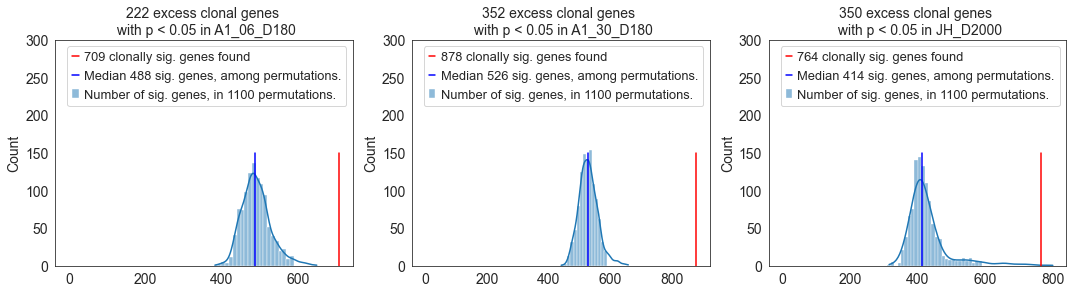

In [30]:
pcut = 0.05
sns.set_style('white')
fig,ax = plt.subplots(1,3,figsize=(18,4))
for j,ds in enumerate(data_late):
    num_sig = (all_pvals[ds] < pcut).sum()
    sns.histplot(num_sig.drop('clone_id'), ax=ax[j], kde=True, bins=np.arange(0,600,10),
                label='Number of sig. genes, in {} permutations.'.format(len(all_pvals[ds].columns) - 1))
    nsig = num_sig['clone_id']
    ax[j].axvline(nsig, color='red', ymax = 0.5, label='{} clonally sig. genes found'.format(nsig))
    sig_med = num_sig.drop('clone_id').median()
    ax[j].axvline(sig_med, color='blue', ymax=0.5, 
                  label='Median {:1.0f} sig. genes, among permutations.'.format(sig_med))
    ax[j].legend()
    ax[j].set_ylim(0,300)
    ax[j].set_title('{:1.0f} excess clonal genes \n with p < {} in {}'.format(nsig - sig_med, pcut, ds))

## Identifying clonal genes

We use the permuted clone labels together with the ANOVA F p-values to identify clonal genes while managing false discovery rate.

In [31]:
for ds in data_late:
    ads[ds].var['nz_ratio'] = (ads[ds].to_df() > 0).sum() / ads[ds].n_obs

In [32]:
shuff_cols = ['Shuffle_'+str(j) for j in range(1000)]
test_cols = ['clone_id'] + ['Shuffle_'+str(j) for j in range(1000,1100)]

In [33]:
def adj_pval_binned(ad, pv, test_cols, shuff_cols, bins=20, corrected=True, verbose=False):
    nz_cut = pd.qcut(ad.var.nz_ratio, bins)
    p_adj_list = []
    for nz_bin in nz_cut.unique():
        if verbose:
            print('Processing genes with nonzero ratio in {}'.format(nz_bin))
        genes_bin = nz_cut[nz_cut == nz_bin].index
        bin_pvals = pv.loc[genes_bin]
        shuff_pvals = bin_pvals[shuff_cols]
        now_time = time()
        shuff_pvals = np.sort(shuff_pvals, axis=None)
        then_time = time()
        if verbose:
            print('Sorting {} p-values took {} seconds.'.format(len(shuff_pvals), then_time - now_time))
        test_pvals = bin_pvals[test_cols].values
        now_time = time()
        places = np.searchsorted(shuff_pvals, test_pvals )
        then_time = time()
        if verbose:
            print('Finding places for {} p-values in sorted list took {} seconds.'.format(test_pvals.shape, 
                                                                                         then_time-now_time))
        denominator = 1 + len(shuff_pvals)
        numerator = 1 + places
        p_adj = pd.DataFrame(numerator / denominator, index=bin_pvals.index, columns=test_cols)
        if corrected:
            corrector = test_pvals.shape[0]
            p_adj = (p_adj * corrector).clip(0,1)
        p_adj_list.append(p_adj)
    return pd.concat(p_adj_list)

In [34]:
p_permadj = {}
for ds in data_late:
    print('Adjusting p-values for {}'.format(ds))
    p_permadj[ds] = adj_pval_binned(ads[ds], all_pvals[ds], test_cols, shuff_cols, corrected=True)

Adjusting p-values for A1_06_D180
Adjusting p-values for A1_30_D180
Adjusting p-values for JH_D2000


In [35]:
sig_genes = {}
for ds in data_late:
    sig_df = (p_permadj[ds] < 0.05)
    #print(ds, sig_df.sum())
    sig_genes[ds] = list(sig_df.clone_id[sig_df.clone_id].index)
    sig_genes[ds].sort()
    print('The significant genes for {} are {}'.format(ds, ', '.join(sig_genes[ds])))
    FDs = sig_df.sum()[1:].mean()
    print('{} expected by chance.'.format(FDs))
    hrule()

The significant genes for A1_06_D180 are AOAH, C1orf228, CD300A, COL18A1, FAM13A, FCGR3A, FCRL6, FGFBP2, GNLY, GPR56, GZMB, GZMH, GZMK, IFNG-AS1, KCNN4, KLRB1, KLRD1, LDHB, LTB, LTBP4, NKG7, NOSIP, PAX8-AS1, RP11-23P13.6, RPLP0P6, SELL
0.89 expected by chance.
The significant genes for A1_30_D180 are ALOX5AP, AMICA1, ARPC2, C1orf162, CACNA2D4, CD300A, CD5, CD7, CD8B, CPA5, DDX43, FCGR3A, FTH1, GFPT2, GNLY, GZMH, HAVCR2, HLA-DRB1, HLA-DRB5, HOPX, HOXB2, IL12RB2, IL7R, ITGB1, KLRD1, KLRG1, LMNA, NCAPG2, NKG7, NSG1, OSBPL10, PATL2, PRSS21, PTPRM, SATB1, SPON2, STAM2, ZNF683
0.96 expected by chance.
The significant genes for JH_D2000 are ANXA2, AOAH, BZRAP1, CARNS1, CCR7, CD244, CD300A, CD63, CD7, CHST2, CMKLR1, COL6A2, CPNE2, CTSW, DGKA, EFHD2, F2R, FCGR3A, FCGR3B, FCRL3, FCRL6, FGFBP2, FGR, GNLY, GPR56, GZMB, GZMH, GZMK, IFITM2, IKZF2, IL7R, ITGAL, ITGAM, KLRB1, LDLRAP1, LGALS1, LTB, LY6E, MIR4435-1HG, MYL6, NELL2, NKG7, OSBPL5, PRF1, PRSS30P, RP11-16F15.2, RP5-1074L1.1, RPL13AP5, RPLP0P

In [36]:
p_sig = {}
for ds in data_late:
    p_sig[ds] = all_pvals[ds]['clone_id'].loc[sig_genes[ds]].sort_values()
    print(ds)
    display(p_sig[ds][:10])
    hrule()
    

A1_06_D180


gene_name
GNLY        3.328895e-14
KLRB1       5.119753e-12
GZMH        1.007140e-11
NKG7        1.101882e-10
KCNN4       2.341570e-10
FGFBP2      5.742898e-09
PAX8-AS1    6.489294e-09
KLRD1       9.585327e-09
FCGR3A      1.374055e-07
COL18A1     2.129986e-07
Name: clone_id, dtype: float64

A1_30_D180


gene_name
GNLY        6.048940e-30
GZMH        1.167149e-21
ALOX5AP     6.559285e-12
AMICA1      6.822364e-12
ZNF683      1.344884e-10
CD5         3.344367e-10
GFPT2       1.445724e-09
IL12RB2     2.103794e-09
HOXB2       2.653543e-09
HLA-DRB1    6.773899e-09
Name: clone_id, dtype: float64

JH_D2000


gene_name
GZMB      9.369417e-31
FCGR3A    2.892994e-23
TYROBP    2.330855e-22
GZMH      1.472378e-21
TIGIT     7.188909e-21
GNLY      9.935832e-16
FCGR3B    3.851698e-13
ZNF683    4.179384e-13
NKG7      7.417486e-13
CD244     4.821072e-12
Name: clone_id, dtype: float64

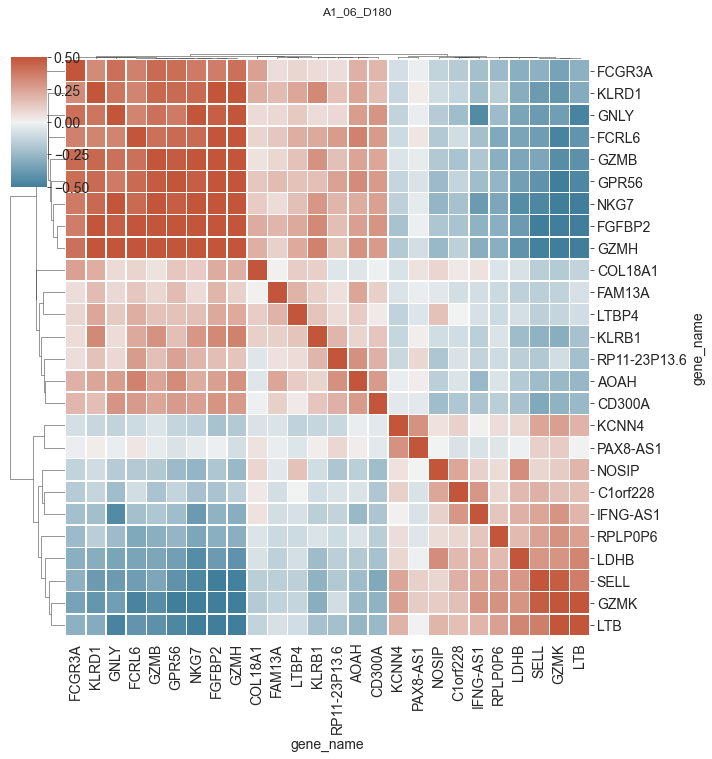

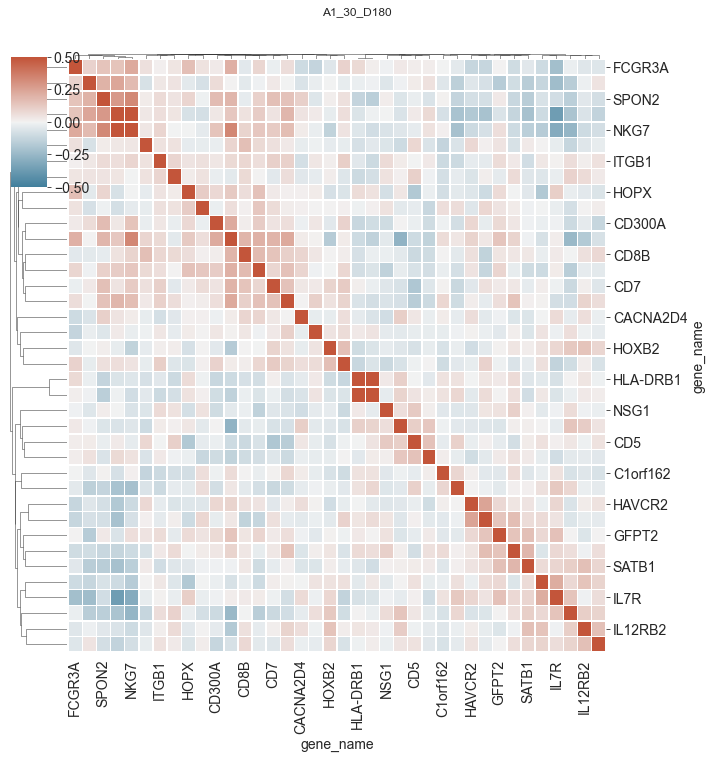

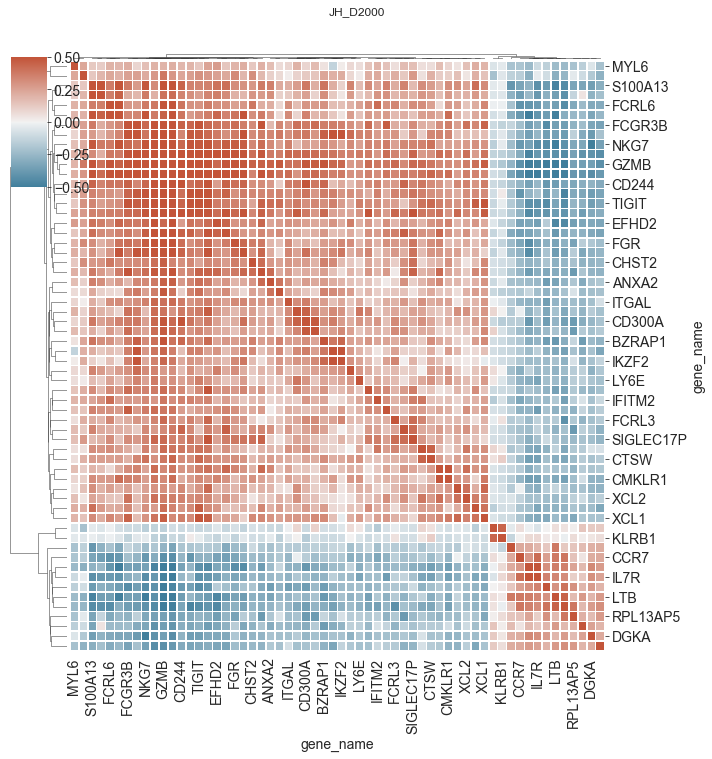

In [37]:
for ds in data_late:
    corr = ads[ds].to_df()[sig_genes[ds]].corr()
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    g = sns.clustermap(corr, cmap=cmap, vmax=0.5, vmin=-0.5, center=0,
                         linewidths=.5, cbar_kws={"shrink": .5},
                         dendrogram_ratio = (0.1,0.01))
    g.fig.suptitle(ds, y=1.05)

    plt.show()

In [38]:
genes_interesting = ['GZMH','GZMB','NKG7','KLRD1','GNLY',
                     'CD300A','AOAH','KCNN4', 'PAX8-AS1','ALOX5AP', 'AMICA1', 'NOSIP', 'ZNF683', 
                     'GFPT2', 'HLA-DRB1', 'CD5', 'TYROBP', 'TIGIT', 
                     'SELL','GZMK']

... storing 'clone_id' as categorical


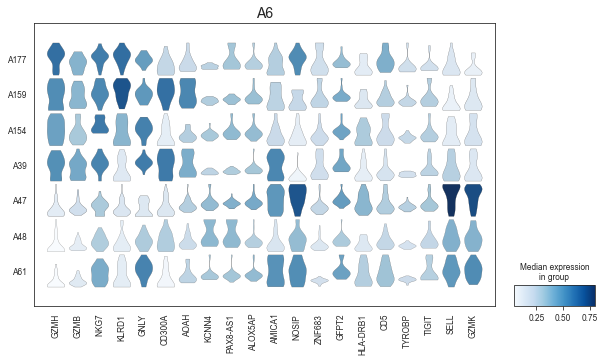

In [39]:
#fig,ax = plt.subplots(1,1,figsize=(10,5))
c_order = ['A177','A159','A154','A39','A47','A48','A61']
g = sc.pl.stacked_violin(ads[a6],genes_interesting,groupby='clone_id', figsize=(10,5),
                         standard_scale='obs', categories_order = c_order, show=False)
g['mainplot_ax'].set_title('A6')
plt.show()

... storing 'clone_id' as categorical


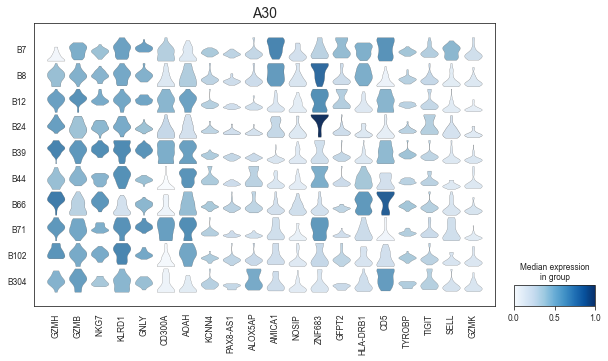

In [40]:
c_order = ads[a30].to_df()['GZMH'].groupby(ads[a30].obs.clone_id).mean()
c_order = c_order.sort_values().index

g = sc.pl.stacked_violin(ads[a30],genes_interesting,groupby='clone_id', figsize=(10,5),
                         category_order = c_order, standard_scale='obs', show=False)
g['mainplot_ax'].set_title('A30')
plt.show()

... storing 'clone_id' as categorical


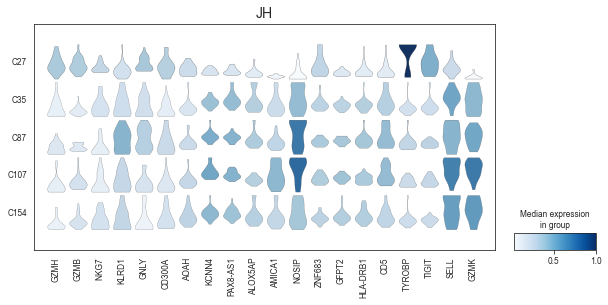

In [41]:
c_order = ads[jh].to_df()['GZMH'].groupby(ads[jh].obs.clone_id).mean()
c_order = c_order.sort_values().index

g = sc.pl.stacked_violin(ads[jh],genes_interesting,groupby='clone_id', figsize=(10,4),
                         category_order = c_order, standard_scale='obs', show=False)
g['mainplot_ax'].set_title('JH')
plt.show()

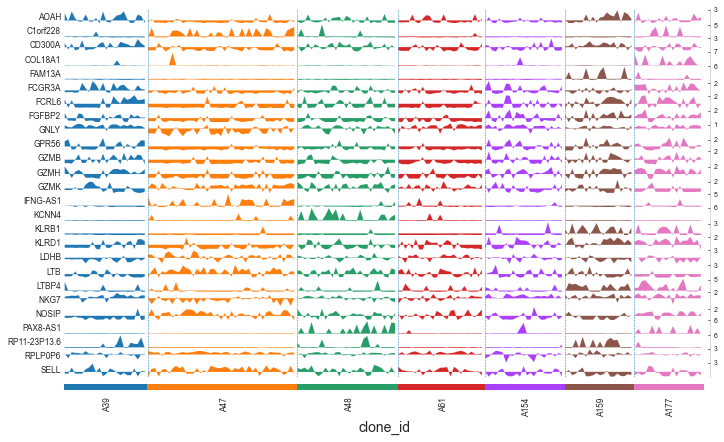

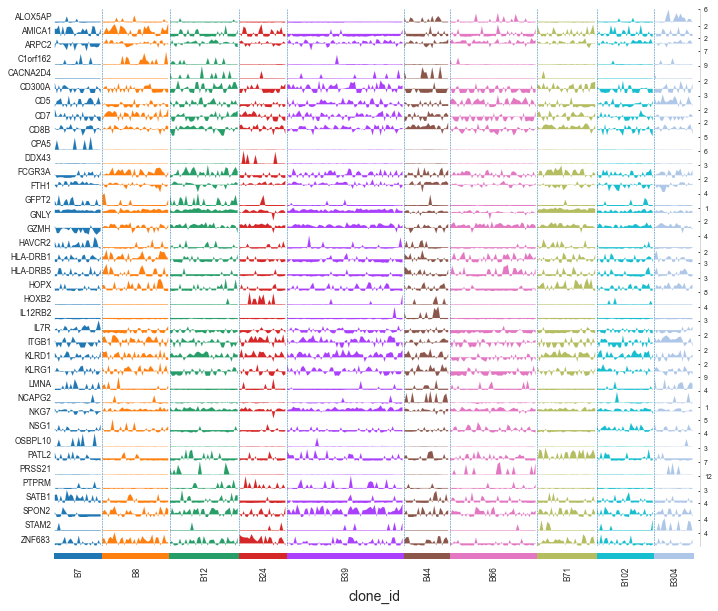

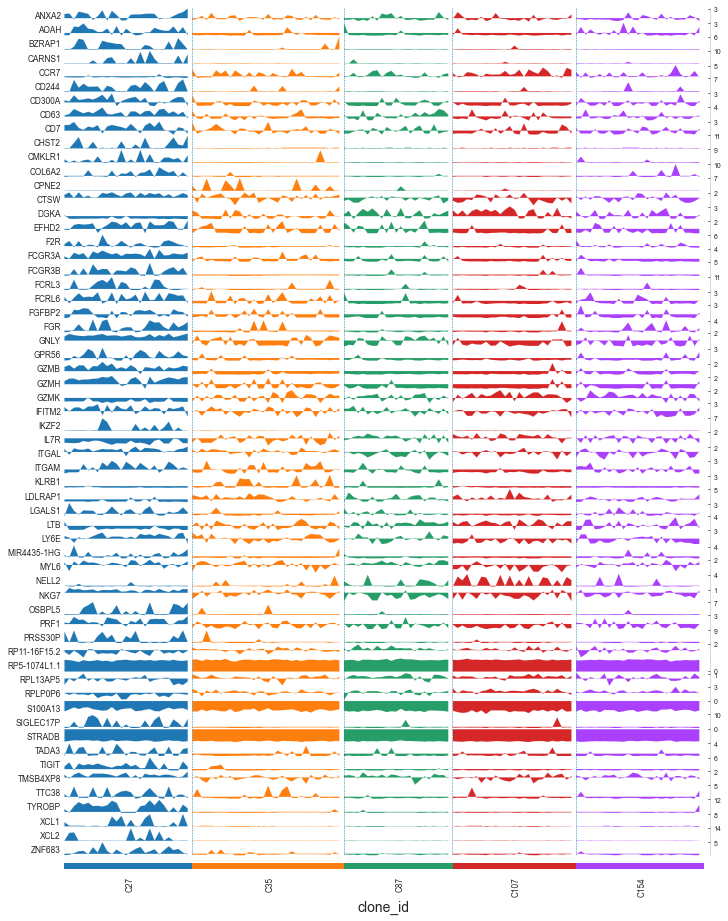

In [58]:
for ds in data_late:
    sc.pl.tracksplot(ads[ds], sig_genes[ds], groupby='clone_id', title=ds)

In [1]:
fig,ax = plt.subplots(1,3,figsize=(18,8))
sig_genes = {}

for j,ds in enumerate(data_late):
    plot_df = pd.DataFrame(index = ads[ds].var_names)
    plot_df['Nonzero ratio'] = ads[ds].var.nz_ratio
    plot_df['p_.5'] = all_pvals[ds][shuff_cols].quantile(0.5, axis=1)
    plot_df['p_.05'] = all_pvals[ds][shuff_cols].quantile(0.05, axis=1)
    plot_df['p_.01'] = all_pvals[ds][shuff_cols].quantile(0.01, axis=1)
    plot_df['p_.001'] = all_pvals[ds][shuff_cols].quantile(0.001, axis=1)
    plot_df['real'] = all_pvals[ds].clone_id

    sns.scatterplot(x = 'Nonzero ratio', y = 'real', data = plot_df, color='black', ax=ax[j])
    
    sns.scatterplot(x = 'Nonzero ratio', y = 'p_.01', data=plot_df, alpha=0.25, ax=ax[j])
    ax[j].axhline(0.01, color='blue')
    sns.scatterplot(x = 'Nonzero ratio', y = 'p_.001', data=plot_df, alpha=0.25, ax=ax[j])
    ax[j].axhline(0.001, color='orange')
    
    sns.scatterplot(x = 'Nonzero ratio', y = 'p_.5', data=plot_df, alpha=0.5, ax=ax[j], color='gray')
    ax[j].axhline(0.05, color='gray')
    
    sns.scatterplot(x = 'Nonzero ratio', y = 'p_.05', data=plot_df, alpha=0.5, ax=ax[j])
    
    sig_genes[ds] = list(p_permadj[ds][p_permadj[ds] < 0.05].index)
    sns.scatterplot(x = 'Nonzero ratio', y = 'real', data=plot_df.loc[sig_genes[ds]], color='red', 
                    ax=ax[j], marker='x', s=50)
    ax[j].axhline(0.05, color='green')
    ax[j].set_yticks([0.05] + [10**(-n) for n in range(0,10)])
    ax[j].set_ylabel('Computed p-value')
    #ax[j].set_ylim(10**(-10),1.0)
    ax[j].set_yscale('log')
    ax[j].set_title(ds)
#plt.yscale('log')
plt.show()

NameError: name 'plt' is not defined

In [39]:
for ds in data_late:
    print('Clonally significant genes in {} are {}'.format(ds, ', '.join(sig_genes[ds])))
    print('---')
    print('Clone populations: ')
    display(ads[ds].obs.clone_id.value_counts())
    hrule()

Clonally significant genes in A1_06_D180 are SELL, NOSIP, COL18A1, GZMK, C1orf228, GPR56, LTBP4, KLRB1, IFNG-AS1, KCNN4, FCRL6, FCGR3A, GZMH, GZMB, PAX8-AS1, FGFBP2, KLRD1, LDHB, CD300A, LTB, AOAH, NKG7, GNLY, RPLP0P6, CD8B
---
Clone populations: 


A47     43
A48     29
A61     25
A39     24
A154    23
A159    20
A177    20
Name: clone_id, dtype: int64

Clonally significant genes in A1_30_D180 are IL12RB2, HOXB2, IL7R, NCAPG2, PRSS21, CD300A, OSBPL10, HLA-DRB1, AMICA1, PATL2, HOPX, ALOX5AP, HAVCR2, GFPT2, ZNF683, ITGB1, CD5, SPON2, CPA5, GZMB, FCGR3A, KLRD1, CD8B, ARPC2, DDX43, GZMH, NKG7, GNLY
---
Clone populations: 


B39     59
B66     44
B12     35
B8      34
B71     30
B102    29
B24     24
B7      24
B44     23
B304    20
Name: clone_id, dtype: int64

Clonally significant genes in JH_D2000 are LDLRAP1, CD52, RP11-16F15.2, CTSW, MYL6, ITGAL, GZMK, LTB, ZNF683, FGR, FCGR3B, NELL2, GZMH, GZMB, GPR56, TBX21, BZRAP1, FGFBP2, F2R, AOAH, FCRL3, OSBPL5, KLRB1, CMKLR1, PRSS30P, TYROBP, SIGLEC17P, COL6A2, TIGIT, CD244, IFITM2, CD63, DGKA, ANXA2, CD7, GNLY, CST7, APMAP, IL7R, LY6E, EFHD2, FCRL6, FCGR3A, XCL2, XCL1, PRF1, ITGAM, CD300A, NKG7, IKZF2, LGALS1, CHST2, RPLP0P6, TMSB4XP8
---
Clone populations: 


C35     32
C154    27
C27     27
C107    26
C87     23
Name: clone_id, dtype: int64

In [40]:
ads_z = {}
for ds in data_late:
    ads_z[ds] = sc.pp.scale(ads[ds], copy=True)

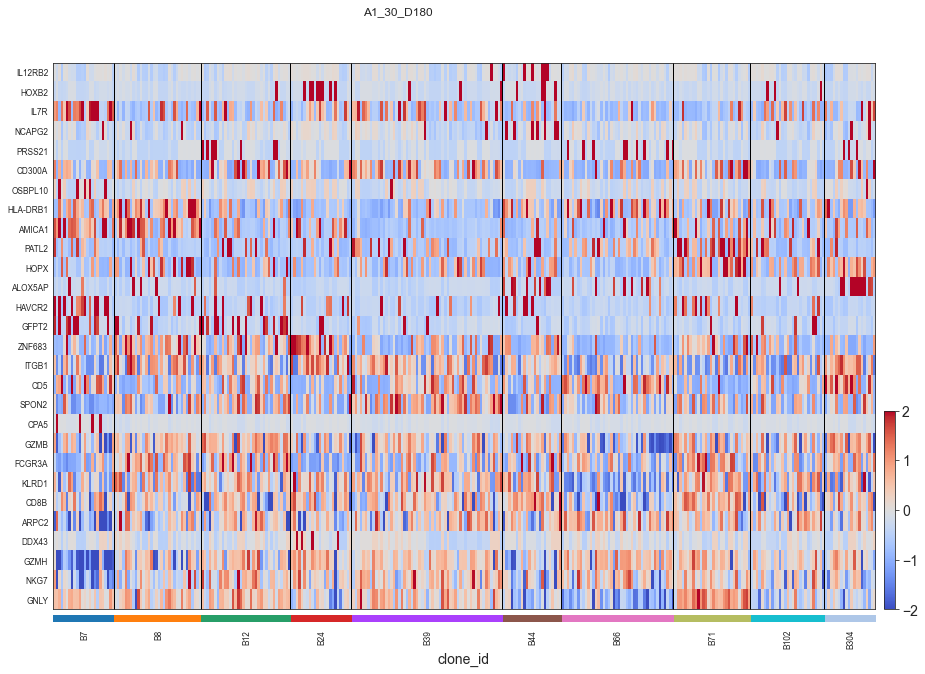

In [46]:
sc.pl.heatmap(ads_z[a30], sig_genes[a30], 'clone_id', show_gene_labels=True, figsize=(15,10),
             swap_axes=True, vmin=-2, vmax=2, cmap='coolwarm', show=False)
plt.suptitle(a30)
plt.show()

In [315]:
def adj_pval_binned(ad, pv, shf, bin_width = 0.1, real_col = 'clone_id', corrected=False):
    bins = np.arange(0,1 + (0.5*bin_width), bin_width)
    nz_cut = pd.cut(ad.var.nz_ratio, bins=bins)
    # shf = [col for col in pv.columns if col[:5] == 'Shuff']
    p_adj_list = []
    for nz_bin in nz_cut.unique():
        genes_bin = nz_cut[nz_cut == nz_bin].index
        bin_pvals = pv.loc[genes_bin]
        outer_less = np.less.outer(bin_pvals[real_col].values, bin_pvals[shf].melt().value.values)
        numless_df = pd.Series(outer_less.sum(axis=1), index=bin_pvals.index)
        denominator = 1 + outer_less.shape[1]
        numerator = denominator - numless_df
        p_adj = numerator / denominator
        if corrected:
            p_adj = (p_adj * outer_less.shape[0]).clip(0,1)
        #print(nz_bin)
        #display(p_adj.sort_values())
        #display(bin_pvals[real_col].sort_values())
        print('Processing genes with nonzero ratio in {}'.format(nz_bin))
        #hrule()
        p_adj_list.append(p_adj)
    return pd.concat(p_adj_list)

In [316]:
p_permadj = {}
for ds in data_late:
    print('Adjusting p-values for {}'.format(ds))
    p_permadj[ds] = adj_pval_binned(ads[ds], all_pvals[ds], shuff_cols, corrected=True)
    hrule()

Adjusting p-values for A1_06_D180
Processing genes with nonzero ratio in (0.6, 0.7]
Processing genes with nonzero ratio in (0.5, 0.6]
Processing genes with nonzero ratio in (0.9, 1.0]
Processing genes with nonzero ratio in (0.4, 0.5]
Processing genes with nonzero ratio in (0.7, 0.8]
Processing genes with nonzero ratio in (0.1, 0.2]
Processing genes with nonzero ratio in (0.2, 0.3]
Processing genes with nonzero ratio in (0.0, 0.1]
Processing genes with nonzero ratio in (0.3, 0.4]
Processing genes with nonzero ratio in (0.8, 0.9]
Processing genes with nonzero ratio in nan
Adjusting p-values for A1_30_D180
Processing genes with nonzero ratio in (0.5, 0.6]
Processing genes with nonzero ratio in (0.2, 0.3]
Processing genes with nonzero ratio in (0.9, 1.0]
Processing genes with nonzero ratio in (0.7, 0.8]
Processing genes with nonzero ratio in (0.3, 0.4]
Processing genes with nonzero ratio in (0.8, 0.9]
Processing genes with nonzero ratio in (0.0, 0.1]
Processing genes with nonzero ratio in 

In [247]:
p_permadj[ds].sort_values()

gene_name
CD8B           0.001
NKG7           0.001
IL7R           0.001
FAM211A-AS1    0.001
GNLY           0.001
               ...  
DUSP12         1.000
PPOX           1.000
USP21          1.000
FAM20B         1.000
TSC22D3        1.000
Length: 8015, dtype: float64

In [218]:
for nz_bin in nz_cut.unique()[:1]:
    genes_bin = nz_cut[nz_cut == nz_bin].index
    bin_pvals = all_pvals[ds].loc[genes_bin]
    numless = np.less.outer(bin_pvals['clone_id'].values, bin_pvals[shuff_cols].melt().value.values).sum(axis=1)
    display(bin_pvals.head())
    numless_df = pd.Series(numless, index=bin_pvals.index)
    display(numless_df)

clone_id  Shuffle_0  Shuffle_1  Shuffle_2  Shuffle_3  Shuffle_4  \
gene_name                                                                    
WASH7P     0.944553   0.786209   0.612296   0.034207   0.432071   0.297911   
CCNL2      0.013702   0.852909   0.181268   0.404810   0.779094   0.330538   
MRPL20     0.510143   0.335141   0.840893   0.557485   0.273613   0.579164   
CDK11B     0.000893   0.393970   0.957490   0.698575   0.739362   0.218217   
TNFRSF14   0.043833   0.449885   0.052342   0.528150   0.300783   0.836524   

           Shuffle_5  Shuffle_6  Shuffle_7  Shuffle_8  ...  Shuffle_990  \
gene_name                                              ...                
WASH7P      0.645060   0.922880   0.617145   0.854605  ...     0.554688   
CCNL2       0.404647   0.069806   0.184527   0.198940  ...     0.112755   
MRPL20      0.635181   0.426033   0.577716   0.305679  ...     0.970897   
CDK11B      0.262378   0.191532   0.096433   0.182848  ...     0.567259   
TNFRSF14    0.379665   0.694854   0.239704   0.886353  ...     0.015034   

           Shuffle_991  Shuffle_992  Shuffle_993  Shuffle_994  Shuffle_995  \
gene_name                                                                    
WASH7P        0.435464     0.417241     0.665842     0.036728     0.231090   
CCNL2         0.826399     0.031584     0.554995     0.994922     0.562015   
MRPL20        0.694093     0.613180     0.788332     0.564048     0.627334   
CDK11B        0.623653     0.807573     0.029244     0.094944     0.488490   
TNFRSF14      0.472012     0.305651     0.143431     0.427808     0.760321   

           Shuffle_996  Shuffle_997  Shuffle_998  Shuffle_999  
gene_name                                                      
WASH7P        0.021404     0.095007     0.650545     0.158238  
CCNL2         0.403532     0.906875     0.364246     0.157112  
MRPL20        0.017318     0.054627     0.171603     0.147193  
CDK11B        0.232304     0.448767     0.874925     0.664802  
TNFRSF14      0.724647     0.284984     0.333149     0.366273  

[5 rows x 1001 columns]

gene_name
WASH7P        19082
CCNL2        346144
MRPL20       171997
CDK11B       350627
TNFRSF14     335720
              ...  
NONO         221625
CXCR3         58574
ATRX-1        49029
EEF1GP5-1    163573
SASH3        327531
Length: 351, dtype: int64

In [200]:
(bin_pvals[shuff_cols].melt().value < bin_pvals['clone_id'])

ValueError: Can only compare identically-labeled Series objects

In [165]:
ads[ds].var.nz_ratio

gene_name
WASH7P          0.467890
MTND1P23        0.293578
MTND2P28        0.972477
hsa-mir-6723    1.000000
RP5-857K21.7    0.357798
                  ...   
F8A2-1          0.087156
TMLHE-1         0.064220
VAMP7           0.105505
RNA5-8SP6       0.509174
PSMA6P1         0.082569
Length: 8015, dtype: float64

In [132]:
plot_df.groupby().count()

Nonzero ratio  p_.5  p_.05  p_.01  p_.001  real
Nonzero ratio                                                 
(0.0, 0.1]              2112  2112   2112   2112    2112  2112
(0.1, 0.2]              2805  2805   2805   2805    2805  2805
(0.2, 0.3]              1276  1276   1276   1276    1276  1276
(0.3, 0.4]               657   657    657    657     657   657
(0.4, 0.5]               351   351    351    351     351   351
(0.5, 0.6]               232   232    232    232     232   232
(0.6, 0.7]               166   166    166    166     166   166
(0.7, 0.8]               111   111    111    111     111   111
(0.8, 0.9]                93    93     93     93      93    93

In [133]:
plot_df.groupby(pd.cut(plot_df['Nonzero ratio'], bins=np.arange(0,1,0.1))).quantile(0.01)

Nonzero ratio      p_.5     p_.05     p_.01    p_.001  \
Nonzero ratio                                                          
(0.0, 0.1]          0.032110  0.471153  0.038904  0.003042  0.000014   
(0.1, 0.2]          0.100917  0.467043  0.036655  0.003649  0.000031   
(0.2, 0.3]          0.201835  0.462052  0.036478  0.004199  0.000059   
(0.3, 0.4]          0.302752  0.466097  0.035739  0.004871  0.000105   
(0.4, 0.5]          0.403670  0.461455  0.035865  0.004473  0.000104   
(0.5, 0.6]          0.504587  0.458547  0.037419  0.005072  0.000220   
(0.6, 0.7]          0.600917  0.464943  0.033803  0.004263  0.000122   
(0.7, 0.8]          0.701835  0.464215  0.036826  0.004525  0.000261   
(0.8, 0.9]          0.802752  0.467739  0.036941  0.005176  0.000183   

                       real  
Nonzero ratio                
(0.0, 0.1]     3.032415e-03  
(0.1, 0.2]     1.532342e-03  
(0.2, 0.3]     2.822974e-04  
(0.3, 0.4]     5.422641e-04  
(0.4, 0.5]     9.068690e-05  
(0.5, 0.6]     7.888203e-06  
(0.6, 0.7]     2.044357e-05  
(0.7, 0.8]     2.682997e-10  
(0.8, 0.9]     3.490855e-10

In [121]:
plot_df.groupby('Nonzero ratio').mean()

p_.5     p_.05     p_.01    p_.001      real
Nonzero ratio                                                  
0.018349       0.546400  0.065839  0.004888  0.000373  0.390367
0.022936       0.498232  0.063829  0.017365  0.002108  0.471937
0.027523       0.516017  0.066616  0.009578  0.000786  0.312588
0.032110       0.520772  0.061914  0.009240  0.001505  0.508938
0.036697       0.515841  0.060010  0.010031  0.001302  0.451069
...                 ...       ...       ...       ...       ...
0.981651       0.505139  0.055416  0.012634  0.003436  0.093451
0.986239       0.494365  0.048021  0.010315  0.001111  0.348189
0.990826       0.508659  0.051351  0.010430  0.001505  0.191718
0.995413       0.511951  0.055476  0.011832  0.002161  0.195161
1.000000       0.512004  0.056335  0.012623  0.002281  0.194944

[214 rows x 5 columns]

In [107]:
plot_df['p_.001']

gene_name
WASH7P          0.004388
MTND1P23        0.003442
MTND2P28        0.000830
hsa-mir-6723    0.003797
RP5-857K21.7    0.002992
                  ...   
F8A2-1          0.001819
TMLHE-1         0.001242
VAMP7           0.000473
RNA5-8SP6       0.002124
PSMA6P1         0.000792
Name: p_.001, Length: 8015, dtype: float64

In [106]:
beats_100 = (all_pvals[ds].clone_id < all_pvals[ds][shuff_cols[:100]].min(axis=1))
beats_100.sum()

255

In [101]:
all_pvals[ds][shuff_cols[:100]].min(axis=1)

gene_name
WASH7P          0.007064
MTND1P23        0.004609
MTND2P28        0.001701
hsa-mir-6723    0.004878
RP5-857K21.7    0.002995
                  ...   
F8A2-1          0.001821
TMLHE-1         0.003881
VAMP7           0.007489
RNA5-8SP6       0.002165
PSMA6P1         0.015871
Length: 8015, dtype: float64

95 8468
116 8658


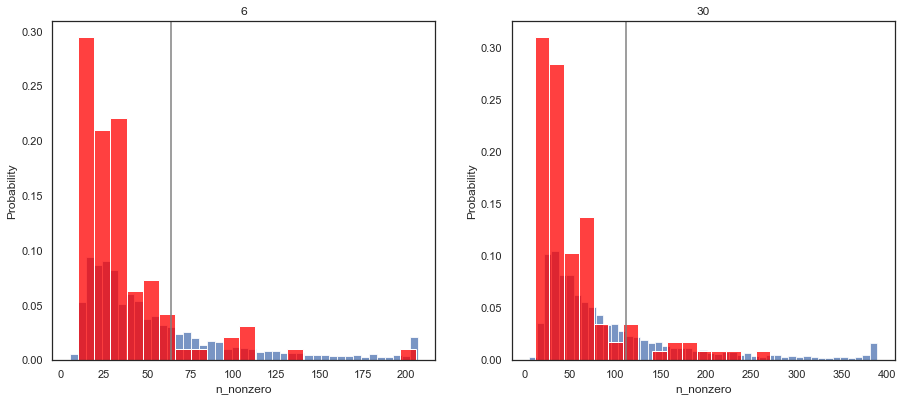

In [197]:
mincells = {}
pcut = 1e-3

fig,ax = plt.subplots(1,2, figsize=(15,6))
for i,ds in enumerate(all_pvals.keys()):
    shuff_sig = (all_pvals[ds][shuff_cols] < pcut).sum(axis=1)
    suspect_genes = list(shuff_sig[shuff_sig >= 2].index)
    sns.histplot(ads[ds].var.n_nonzero, stat='probability', ax=ax[i])
    
    sns.histplot(ads[ds].var.n_nonzero.loc[suspect_genes], stat='probability',
                 ax=ax[i], color='red')
    print(len(suspect_genes), len(ads[ds].var.n_nonzero))
    mincells[ds] = ads[ds].var.n_nonzero.loc[suspect_genes].quantile(0.9)
    ax[i].axvline(mincells[ds], color='gray')
    ax[i].set_title(ds)

In [198]:
clonal_genes = {}
for ds in lates:
    nnz = (ads[ds].var.n_nonzero >= mincells[ds])
    nnz_genes = nnz[nnz].index
    psig = (all_pvals[ds].clone_id < pcut)
    psig_genes = psig[psig].index
    clonal_genes[ds] = [gene for gene in psig_genes if gene in nnz_genes]
    print('Clonal genes for {}: {}'.format(ds, ' '.join(clonal_genes[ds])))
    # display((all_pvals[ds].loc[nnz_genes][shuff_cols] < pcut))
    fdisc = (all_pvals[ds].loc[nnz_genes][shuff_cols] < pcut).sum().median()
    print('Median false discoveries {}'.format(fdisc))
    hrule()

Clonal genes for 6: FGR TGFBR3 FCRL6 FCGR3A SELL ITPKB KLRD1 LDHB PPP1CC GZMH GZMB FOS INO80E ITGAM GPR56 COTL1 CCL4 CD300A CD7 S1PR5 NOSIP NKG7 GNLY CD8B CST7 NKTR RP11-393N4.2 AP2M1 FGFBP2 RHOH OSTC IL7R GZMK TCF7 HLA-H LTB RPS12 EEF1A1P6 AOAH CD99
Median false discoveries 3.0
Clonal genes for 30: ZNF683 SRSF4 RNVU1-19 FCGR3A ITGB1 ATHL1 CD6 CD5 FTH1 PRSS23 AMICA1 KLRG1 KLRB1 KLRD1 RGCC GZMH GZMB PATL2 SCAMP2 GPR56 CD300A CD7 NKG7 GNLY CD8B MIR4435-1HG AC009951.1 ARPC2 DSTN BCR MIAT APOBEC3C PLXND1 SPON2 FGFBP2 RHOH HOPX RP11-408P14.1 IL7R HLA-DRB1 EEF1A1P6 AOAH POLR2J3 MT-ND4 MT-ND5
Median false discoveries 3.0


In [241]:
all_pvals

{6:               clone_id  Shuffle_0  Shuffle_1  Shuffle_2  Shuffle_3  Shuffle_4  \
 gene_name                                                                       
 WASH7P        0.342071   0.032161   0.187118   0.380783   0.706622   0.161578   
 MTND1P23      0.865095   0.664065   0.169803   0.812866   0.227068   0.921686   
 MTND2P28      0.650502   0.280591   0.380901   0.097452   0.665791   0.571246   
 hsa-mir-6723  0.465810   0.666613   0.337408   0.396992   0.234582   0.816718   
 RP5-857K21.7  0.147334   0.768158   0.221268   0.651872   0.406012   0.843862   
 ...                ...        ...        ...        ...        ...        ...   
 F8A2-1        0.646378   0.249966   0.953310   0.427560   0.736080   0.284587   
 VAMP7         0.004312   0.357450   0.917666   0.801305   0.524847   0.052007   
 WASH6P        0.142065   0.390148   0.469879   0.686446   0.775431   0.183972   
 RNA5-8SP6     0.088281   0.373863   0.627349   0.942723   0.634822   0.853524   
 PSMA6P1     

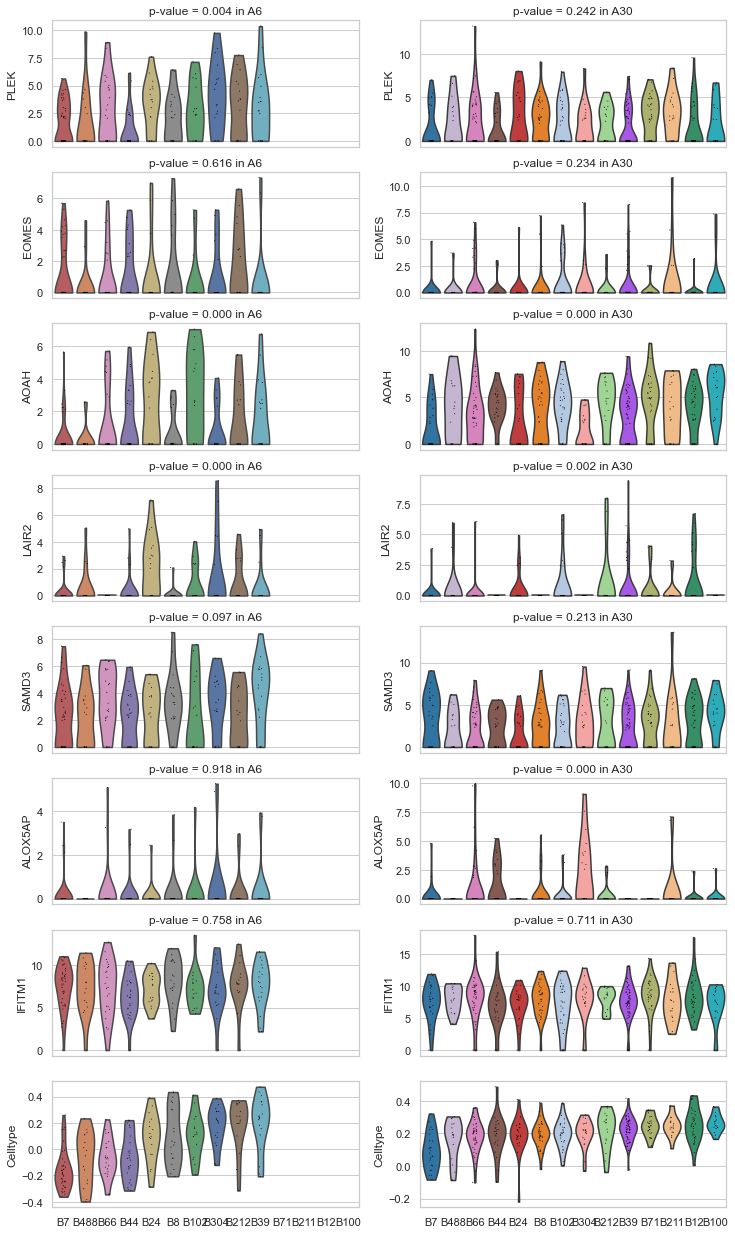

In [259]:
sns.set_style('whitegrid')
clone_ord = {}

#genelist = ['GNLY','GZMH','AOAH','CD7','KLRD1','EEF1A1P6','MT-ND4','MT-ND5','Celltype']
genelist = ['PLEK','EOMES','AOAH','LAIR2','SAMD3', 'ALOX5AP','IFITM1','Celltype']
#genelist = clonal_genes[6]
gl = len(genelist)

fig,ax = plt.subplots(gl,2,figsize=(12,gl*2.5 + 1), sharex=True)

for i,ds in enumerate([6,30]):
    clone_ord[ds] = list(ads[ds].obs.groupby('clone_id').Celltype.mean().sort_values().index)
    for j,gene in enumerate(genelist):
        sc.pl.violin(ads[ds], gene, 'clone_id', ax=ax[j,i], show=False, order=clone_ord[ds])
        ax[j,i].set_xlabel('')
        if gene != 'Celltype':
            ax[j,i].set_title('p-value = {:1.3f} in A{}'.format(all_pvals[ds].loc[gene,'clone_id'],ds))

plt.show()

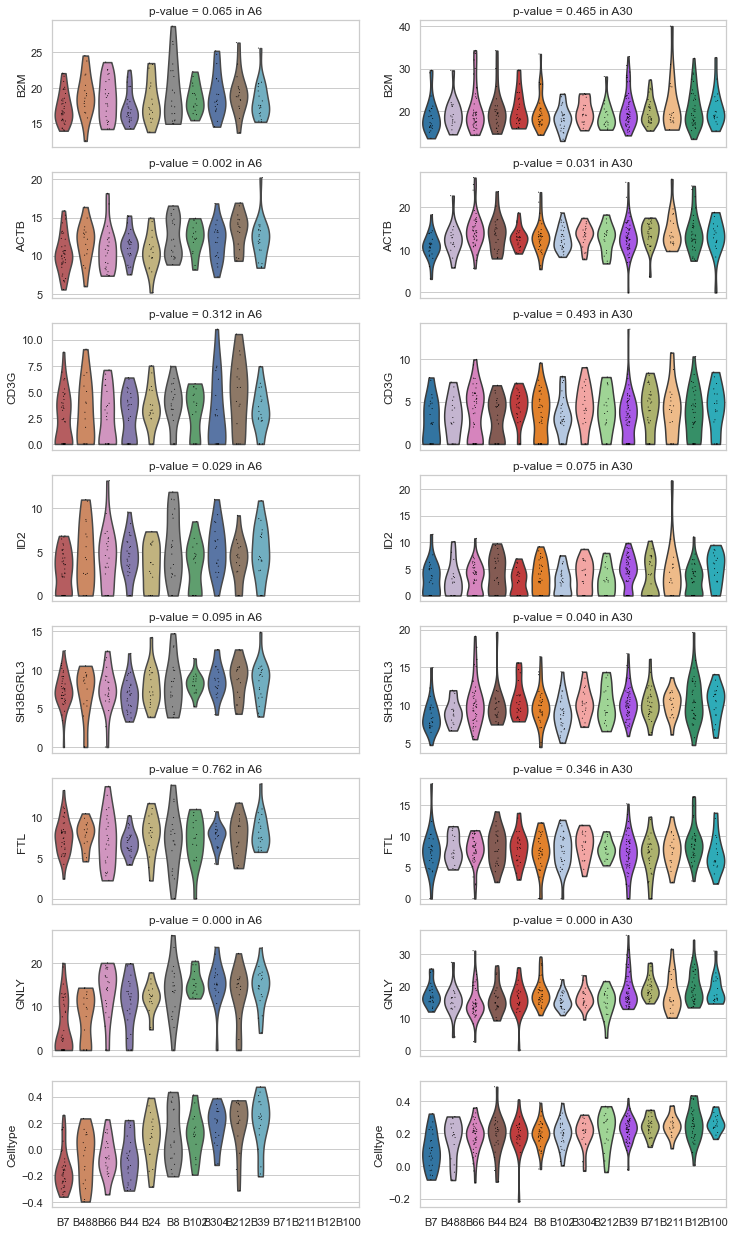

In [248]:
sns.set_style('whitegrid')
clone_ord = {}

#genelist = ['GNLY','GZMH','AOAH','CD7','KLRD1','EEF1A1P6','MT-ND4','MT-ND5','Celltype']
genelist = ['B2M', 'ACTB', 'CD3G', 'ID2', 'SH3BGRL3', 'FTL', 'GNLY', 'Celltype']
#genelist = clonal_genes[6]
gl = len(genelist)

fig,ax = plt.subplots(gl,2,figsize=(12,gl*2.5 + 1), sharex=True)

for i,ds in enumerate([6,30]):
    clone_ord[ds] = list(ads[ds].obs.groupby('clone_id').Celltype.mean().sort_values().index)
    for j,gene in enumerate(genelist):
        sc.pl.violin(ads[ds], gene, 'clone_id', ax=ax[j,i], show=False, order=clone_ord[ds])
        ax[j,i].set_xlabel('')
        if gene != 'Celltype':
            ax[j,i].set_title('p-value = {:1.3f} in A{}'.format(all_pvals[ds].loc[gene,'clone_id'],ds))

plt.show()

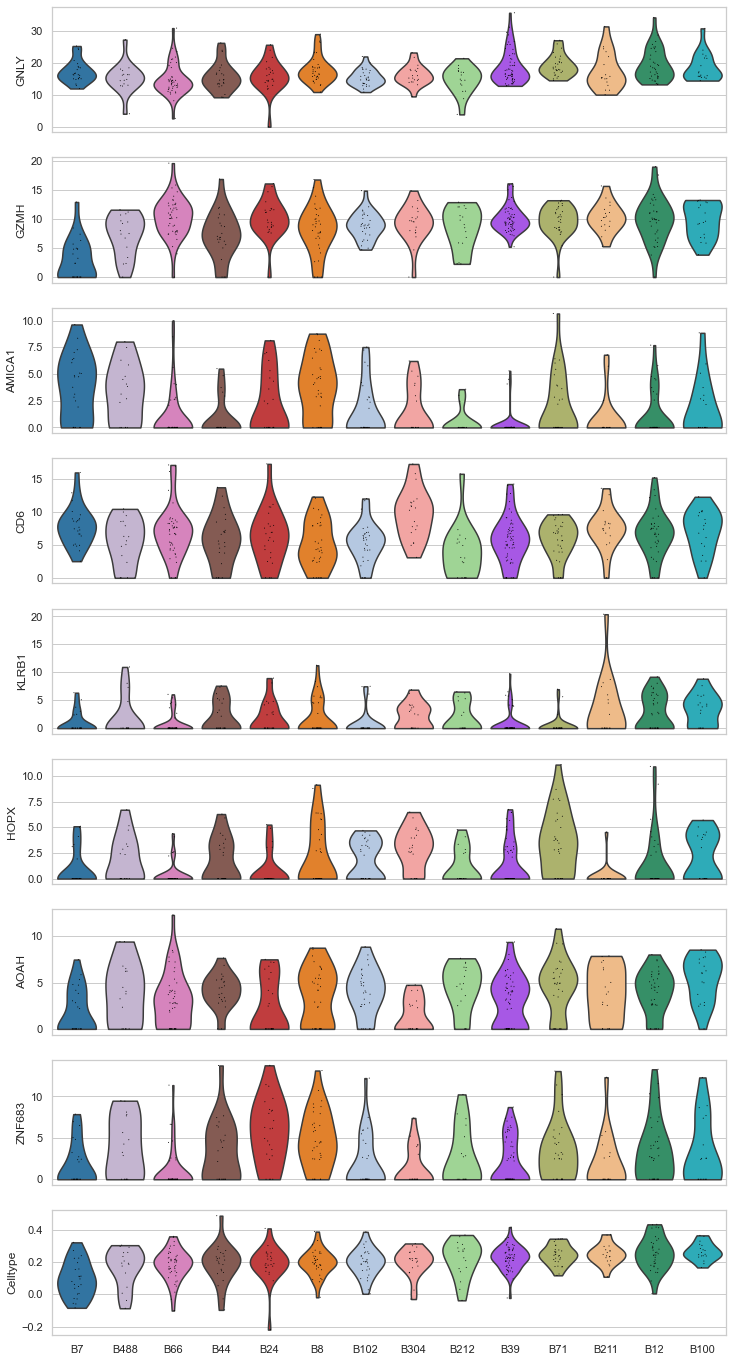

In [236]:

sns.set_style('whitegrid')

clone_ord = list(ads[30].obs.groupby('clone_id').Celltype.mean().sort_values().index)

genelist = ['GNLY','GZMH','AMICA1','CD6','KLRB1','HOPX', 'AOAH', 'ZNF683', 'Celltype']
gl = len(genelist)
fig,ax = plt.subplots(gl,1,figsize=(12,gl*2.5 + 1), sharex=True)

for j,gene in enumerate(genelist):
    sc.pl.violin(ads[30], gene, 'clone_id', ax=ax[j], show=False, order=clone_ord)
    ax[j].set_xlabel('')

plt.show()

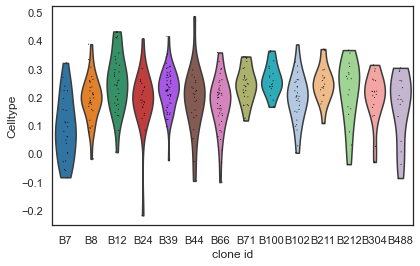

In [212]:
sc.pl.violin(ads[30], ['Celltype'], 'clone_id')

In [96]:
ad_BIG_z = sc.pp.scale(ad_BIG, copy=True)

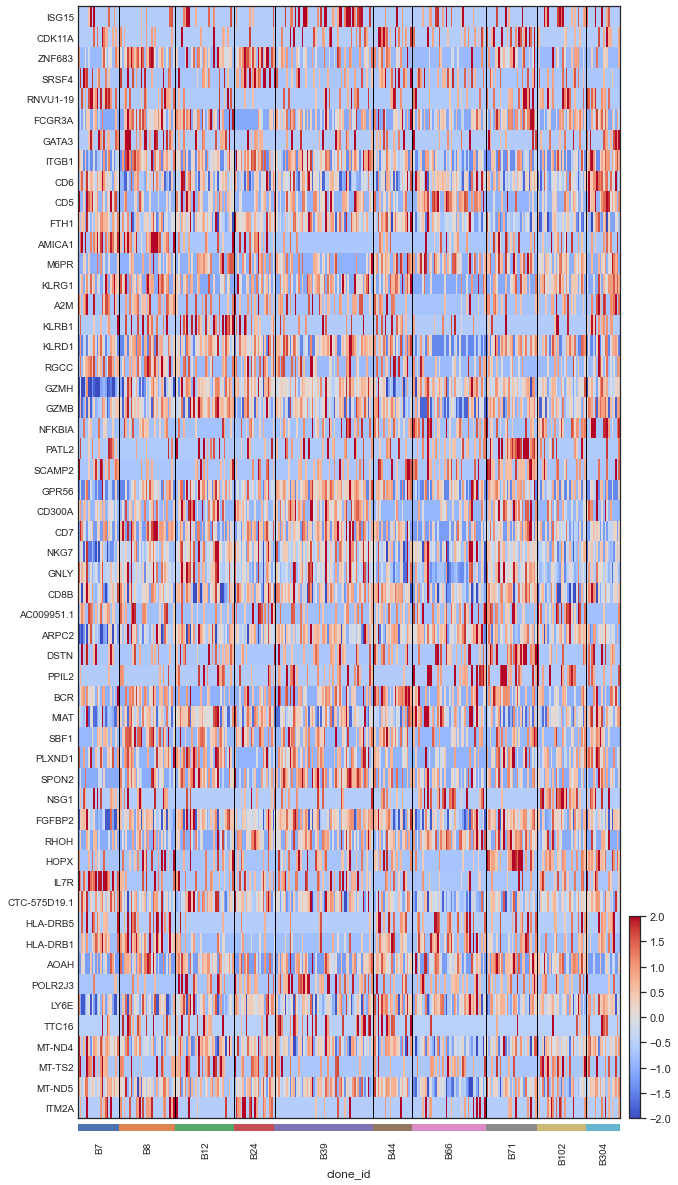

In [105]:
sc.pl.heatmap(ad_BIG_z, clonal_genes['big'], 'clone_id', 
              vmin=-2, vmax=2, show_gene_labels=True,
              cmap='coolwarm', swap_axes=True, figsize=(10,20))

In [121]:
ad_BIG_scaled_df = ad_BIG.to_df().multiply(1/ad_BIG.to_df().mean(), axis=1)
ad_BIG_scaled = ad_BIG.copy()
ad_BIG_scaled.X = ad_BIG_scaled_df
ad_BIG_scaled

AnnData object with n_obs × n_vars = 320 × 8658
    obs: 'Celltype', 'Donor', 'DonorDay', 'G2M_score', 'S_score', 'Timepoint', 'clone_id', 'is_clone0', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'phase', 'total_counts', 'total_counts_mt'
    var: 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'transcript_length', 'variances', 'variances_norm'
    uns: 'clone_id_colors'

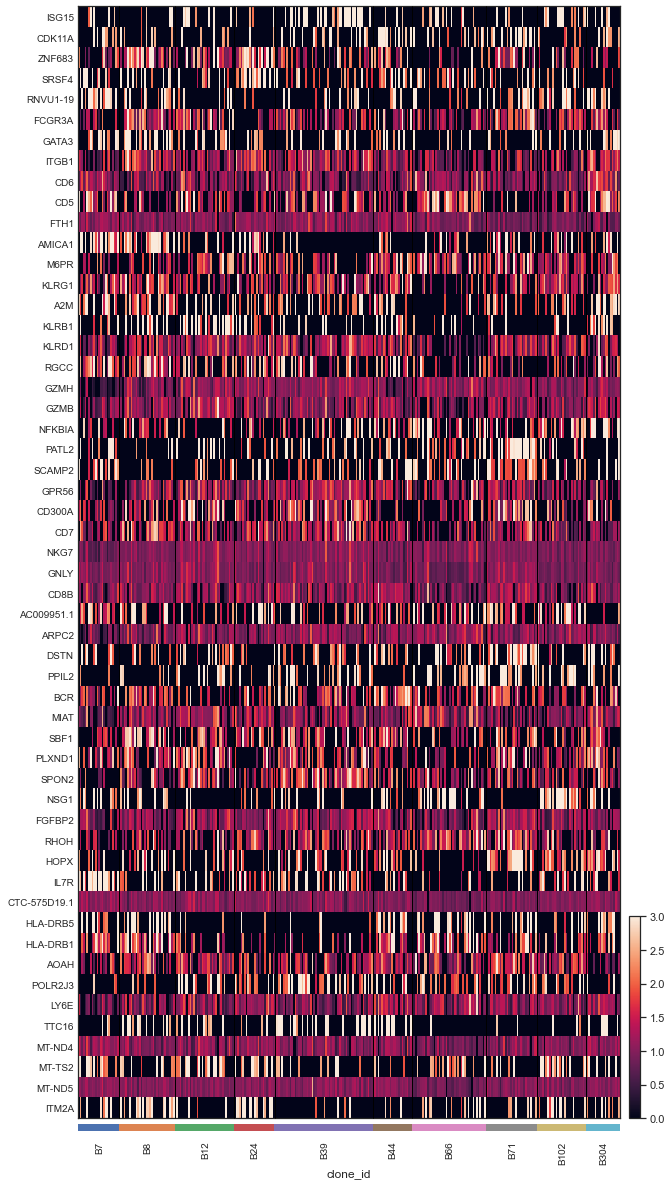

In [124]:
sc.pl.heatmap(ad_BIG_scaled, clonal_genes['big'], 'clone_id', 
              show_gene_labels=True, vmax=3, 
              swap_axes=True, figsize=(10,20))

In [89]:
ad_BIG

View of AnnData object with n_obs × n_vars = 320 × 8658
    obs: 'Celltype', 'Donor', 'DonorDay', 'G2M_score', 'S_score', 'Timepoint', 'clone_id', 'is_clone0', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'phase', 'total_counts', 'total_counts_mt'
    var: 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'transcript_length', 'variances', 'variances_norm'

In [90]:
clonal_genes['big']

['ISG15',
 'CDK11A',
 'ZNF683',
 'SRSF4',
 'RNVU1-19',
 'FCGR3A',
 'GATA3',
 'ITGB1',
 'CD6',
 'CD5',
 'FTH1',
 'AMICA1',
 'M6PR',
 'KLRG1',
 'A2M',
 'KLRB1',
 'KLRD1',
 'RGCC',
 'GZMH',
 'GZMB',
 'NFKBIA',
 'PATL2',
 'SCAMP2',
 'GPR56',
 'CD300A',
 'CD7',
 'NKG7',
 'GNLY',
 'CD8B',
 'AC009951.1',
 'ARPC2',
 'DSTN',
 'PPIL2',
 'BCR',
 'MIAT',
 'SBF1',
 'PLXND1',
 'SPON2',
 'NSG1',
 'FGFBP2',
 'RHOH',
 'HOPX',
 'IL7R',
 'CTC-575D19.1',
 'HLA-DRB5',
 'HLA-DRB1',
 'AOAH',
 'POLR2J3',
 'LY6E',
 'TTC16',
 'MT-ND4',
 'MT-TS2',
 'MT-ND5',
 'ITM2A']

In [ ]:
p_comp = all_pvals['big'].loc[[gene for gene in P1902_genes if gene in all_pvals['big'].index]]
p_comp

In [ ]:
def matched_nnz(nnz_series, to_match):
    nnz_sort = nnz_series.sort_values()
    match_idx = []
    for tm in to_match:
        i_num = nnz_sort.index.get_loc(tm)
        matched = nnz_sort.index[i_num + np.random.choice([-3,-2,-1,1,2,3])]
        match_idx.append(matched)
    return match_idx


In [ ]:
fig,ax = plt.subplots(3,1,figsize=(10,10), sharex=True, sharey=True)
sns.set_style('whitegrid')
bins = np.array([1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])

sns.histplot(all_pvals['big'].clone_id, kde=False, bins=bins, 
             label='All {} genes'.format(len(all_pvals['big'])), 
            stat = 'probability', ax=ax[0])

sns.histplot(p_comp.clone_id, kde=False, bins=bins, label='{} genes that were significant in P1902'.format(len(p_comp)),
            stat = 'probability', color='orange', ax=ax[1])

p_matched = matched_nnz(nnz_series, p_comp.index)

sns.histplot(all_pvals['big'].clone_id.loc[p_matched], kde=False, bins=bins, 
             label='{} genes matched to P1902 by nonzero-ratio'.format(len(p_matched)), 
            stat = 'probability', color='lightgreen', ax=ax[2])

ax[2].set_xlabel('p-value')
ax[2].set_xticks(bins)
plt.xscale('log')
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

In [ ]:
nnz_series.sort_values().index.get_loc('UTY')

In [ ]:
np.random.choice([1,2,3])

In [ ]:
def matched_nnz(nnz_series, to_match):
    nnz_sort = nnz_series.sort_values()
    match_idx = []
    for tm in to_match:
        i_num = nnz_sort.index.get_loc(tm)
        matched = nnz_sort.index[i_num + np.random.choice([-3,-2,-1,1,2,3])]
        match_idx.append(matched)
    return match_idx

In [ ]:
matched_nnz(nnz_series, ['WASH7P'])

In [ ]:
nnz_series['MPHOSPH8']

In [ ]:
nnz_series = ads['big'].var.n_nonzero

sns.histplot(x=nnz_series, y=all_pvals['big'].clone_id)

In [ ]:
p_comp.drop('clone_id',axis=1).median(axis=1)

In [ ]:
p_comp.clone_id

In [ ]:
clonal_genes['eff']

In [ ]:
clonal_genes['mem']

In [ ]:
clonal_genes['big']

In [ ]:
all_pvals[ds].clone_id < 1e-4

In [ ]:
(all_pvals['mem'] < 1e-3).sum()

## Older stats

In [ ]:
def group_stats(ad, groupby='Clone_ID', kruskal=False):
    X = ad.to_df()
    y = ad.obs[groupby]
    F_pvals = ss.f_oneway(*[X[y == k] for k in np.unique(y)])[1]
    print('ANOVA F complete.')
    if kruskal:
        print('Kruskal-Wallis may take a minute now.')
        K_pvals = X.apply(lambda col : ss.kruskal(*[col[y == k] for k in np.unique(y)])[1])
    chi2_pvals = chi2(X > np.log1p(10),y)[1]
    ad_out = ad.copy()
    ad_out.var['F_pval'] = F_pvals
    if kruskal:
        ad_out.var['K_pval'] = K_pvals
    ad_out.var['chi2_pval'] = chi2_pvals
    return ad_out

In [ ]:
ad_EFF = group_stats(ad_EFF, groupby='clone_id')

In [ ]:
ad_BIG = group_stats(ad_BIG, groupby='clone_id')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
plt.scatter(ad_EFF.var.F_pval, ad_EFF.var.chi2_pval, s=2)
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
ad_EFF.var.F_pval.sort_values()[:20]*10000

In [ ]:
genelist = ad_EFF.var.F_pval.sort_values()[:50].index

mean_df = ad_EFF.to_df().groupby(ad_EFF.obs.clone_id)[genelist].mean()
marked = mean_df.idxmax().sort_values()
genelist = marked.index
desetfontsize()
sc.pl.heatmap(sc.pp.scale(ad_EFF, copy=True), var_names=genelist, groupby='clone_id',
                  show=None, vmin=-2, vmax=2, cmap='coolwarm')

In [ ]:
sc.tl.rank_genes_groups(ad_EFF, 'clone_id', method='wilcoxon')
# to visualize the results
sc.pl.rank_genes_groups_dotplot(ad_EFF, values_to_plot='logfoldchanges', cmap='bwr', vmax=3, vmin=-3)

In [ ]:
sc.pl.rank_genes_groups_dotplot(ad_EFF, values_to_plot='log10_pvals_adj', vmax=3)

# SVM Quickshot

In [ ]:
def CV_map(gs, swap=False, savefig=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))
    if savefig:
        plt.savefig('CV_map.svg')

In [ ]:
def confusion_matrix(X,y,pipe, reps=2, classlist = None, filename=None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    valid_dec = (valid*100).astype(int)
    
    #f, ax = plt.subplots(figsize=(8,7))
    f, ax = plt.subplots(figsize=(1.2,1.25), dpi=300)
    setfontsize()
    #fmt="2.0%"
    sns.heatmap(valid, annot=valid_dec, annot_kws={'fontsize':5}, fmt="d", square=True, linewidths=.25, cbar=None,
                cbar_kws={'fraction':0.02, 'pad':0.02}, ax=ax)
    #cbar = ax.collections[0].colorbar
    #cbar.set_ticks([0, .25, .5, .75, 1])
    #cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_xticks([])
    ax.set_yticks([])
    tickypos = -0.3
    pal = sns.color_palette()
    lut = dict(zip(classes, pal))
    for j,cl in enumerate(classes):
        ax.add_patch(Rectangle((tickypos,j+0.1),0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,tickypos),0.8,0.3, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((len(classes)-tickypos,j+0.1),-0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,len(classes)-tickypos),0.8,-0.3, color=lut[cl],fill=True,clip_on=False))
    ax.set_ylabel("Actual clone")
    ax.set_xlabel("Predicted clone")
    ax.set_title("Predicted clonality (%).".format(correct / total))
    
    if filename:
        set_size(f, (1.2, 1.25))
        plt.savefig(filename, bbox_inches='tight')
    # "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

In [ ]:
def sort_by(df, col, valuelist):
    '''
    Sorts a data frame, according to the values in a column,
    and a chosen order for these values.
    '''
    if set(df[col].unique()) != set(valuelist):
        print('Warning, cannot sort!')
        return df
    value_dict = {valuelist[j]:j for j in range(len(valuelist))}
    df['newcol'] = df[col].apply(lambda v : value_dict[v])
    df.sort_values('newcol', inplace=True)
    df.drop('newcol', axis=1)
    return df

In [ ]:
def downsample(X,y):
    ymin = y.value_counts().min()
    sample = []
    for cl in y.unique():
        cells_cl = y[y == cl].index
        sample_cl = np.random.choice(cells_cl, ymin, replace=False)
        sample = sample + list(sample_cl)
    return X.loc[sample], y.loc[sample]
        

In [ ]:
X = ad_BIG.to_df().copy()
y = ad_BIG.obs.clone_id.copy()

X,y = downsample(X,y)

In [ ]:
y.value_counts()

In [ ]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=2000)) ])

param_grid = dict(skb__k = [2,5,10,25,50,100,150,200,250,300], svm__C = [0.001, 0.01, 0.1, 1.0, 10.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search.fit(X,y)

In [ ]:
desetfontsize()
CV_map(grid_search, swap=True)

In [ ]:
opt_k = grid_search.best_params_['skb__k'] # Use optimal number of genes.
opt_C = grid_search.best_params_['svm__C'] # Use optimal C-parameter for linear SVM.

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))

setfontsize()
confusion_matrix(X,y,SVMpipe, reps=100, classlist = list(y.unique()), filename='panels/Confusion.pdf')

In [ ]:
genes_clonal = ad_BIG.var.F_pval.sort_values()[:20].index

In [ ]:
ad_BIG.var.F_pval.sort_values()[:20] * 10000

In [ ]:
desetfontsize()
sc.pl.stacked_violin(ad_BIG, genes_clonal, groupby='clone_id', figsize=(6,15), cut=0,  
                     standard_scale = 'obs', swap_axes=True, stripplot=True, yticklabels=True, ymin=0)

In [ ]:
ad_BIG

In [ ]:
ad_BIG.var.F_pval

In [ ]:
P1902_genes = ['RP11-465B22.3', 'PER3', 'RP3-477M7.5', 'ID3', 'STMN1', 'SH3BGRL3', 'CD52', 'IFI44L', 'S1PR1', 'CSF1', 'CD2', 'REG4', 'S100A4', 'SLAMF7', 'FCGR3A', 'SELL', 'PFN1P1', 'RGS1', 'IL2RA', 'SRGN', 'IFITM1', 'CD82', 'MALAT1', 'CADM1', 'AMICA1', 'CD9', 'LAG3', 'KLRG1', 'KLRB1', 'KLRD1', 'KLRC3', 'KLRC2', 'KLRC1', 'IFNG', 'ALOX5AP', 'LPAR6', 'RCBTB2', 'NDFIP2', 'GZMB', 'ASB2', 'B2M', 'KIAA0101', 'NPTN', 'ISG20', 'LRRC28', 'IL32', 'MAF', 'COTL1', 'CCL5', 'CCL23', 'CCL3', 'CCL4', 'CCL3L3', 'CCL4L1', 'CCL3L1', 'CCL4L2', 'CD300A', 'LGALS3BP', 'GNG8', 'FTL', 'NKG7', 'LAIR2', 'NCR1', 'AC092580.4', 'ID2', 'FAM49A', 'CRIM1', 'EPAS1', 'PLEK', 'TMSB10', 'STK17B', 'IKZF2', 'CCL20', 'TMSB10P1', 'FTLP3', 'MIR155HG', 'MX1', 'XBP1', 'APOBEC3C', 'EOMES', 'CX3CR1', 'CXCR6', 'CCR2', 'CLDND1', 'RPL38P4', 'GPR15', 'CD200R1', 'SKIL', 'HPGDS', 'GZMA', 'ACTBP2', 'CD74', 'TIMD4', 'LTB', 'NCR3', 'HLA-DRB5', 'HLA-DQB1', 'HLA-DMA', 'HLA-DPA1', 'NT5E', 'SAMD3', 'PDE7B', 'PDGFA', 'ACTB', 'HDAC9', 'AOAH', 'LAT2', 'STEAP1', 'SRRT', 'LRRN3', 'GIMAP7', 'GIMAP4', 'DOCK5', 'RDH10', 'UBA52P5', 'ANXA1', 'RP11-217O12.1', 'MT-TN', 'MT-TE', 'MT-CYB', 'PLS3-1', 'CD40LG', 'AC010970.2']
len(P1902_genes)

In [ ]:
P1902_genes = [gene for gene in P1902_genes if gene in ad_BIG.var_names]
ad_BIG.var.F_pval.loc[P1902_genes].sort_values()

In [ ]:
ad_BIG.var.F_pval['B2M']

In [ ]:
sc.pl.stacked_violin(ad_BIG, ['NSG1','GNLY','GZMB',
                              'HLA-DRB5','HLA-DRB1', 'HLA-DQB1', 
                              'KLRB1','KLRD1','KLRG1', 
                              'AMICA1','TIMD4','DOCK5', 'B2M',
                              'CCL4','CCL5','CD2','CD82','CD84','CD300A'], 
                     groupby='clone_id', standard_scale='var', swap_axes=True,
                     figsize=(6,15))

In [ ]:
ad_BIG.var.F_pval.sort_values()[:20]

In [ ]:
sns.distplot(np.log10(ad_BIG.var.F_pval.loc[P1902_genes]), kde=False)
sns.distplot(np.log10(ad_BIG.var.F_pval), kde=False)
plt.yscale('symlog')